In [71]:
from bitarray import bitarray
import random
import numpy as np
import math

In [72]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [95]:
import pandas as pd
import os

In [96]:
from sklearn import datasets

In [97]:
bcancer = datasets.load_breast_cancer()
X = bcancer.data  
y = bcancer.target
X = StandardScaler().fit_transform(X)

In [98]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(212, 30)
(357, 30)


In [99]:
indices=np.arange(106)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:106]
x_train=np.concatenate((np.array(x_neg[0:106])[indices],x_pos)).reshape(-1,30)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [100]:
x_test = x_neg[106:212].reshape(-1,30)
y_test = y_neg[106:212].reshape(-1,1)

# Kraska Hash Model

In [114]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [115]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Number of nodes: 1


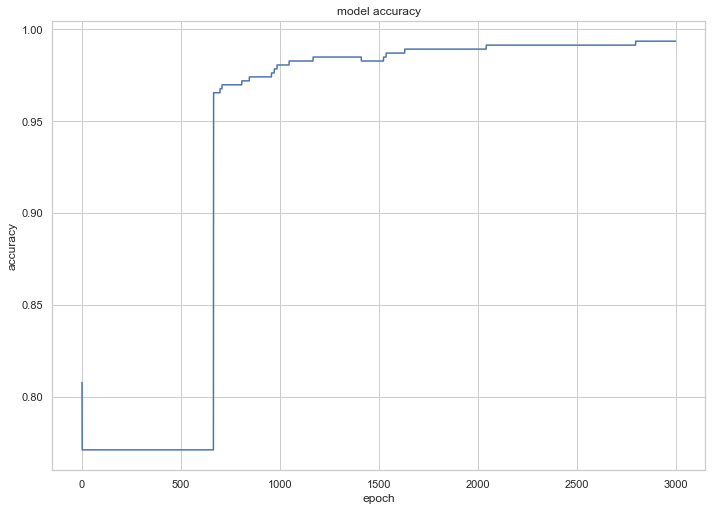

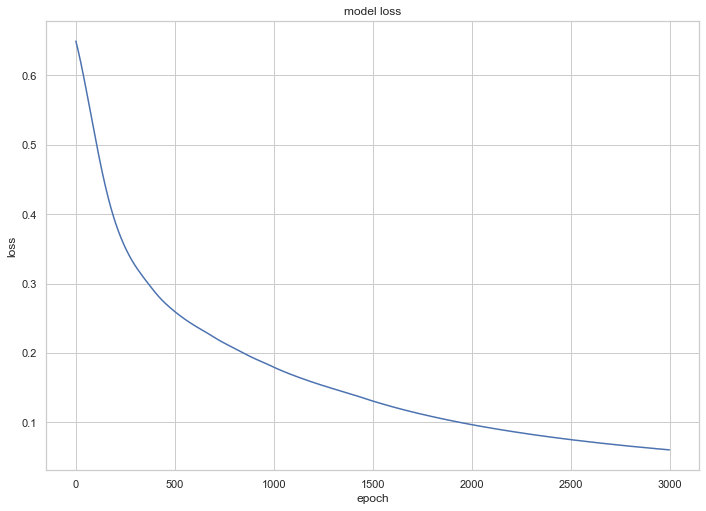

Size: 1162.000000 bits - FPR: 0.943396 



Number of nodes: 2


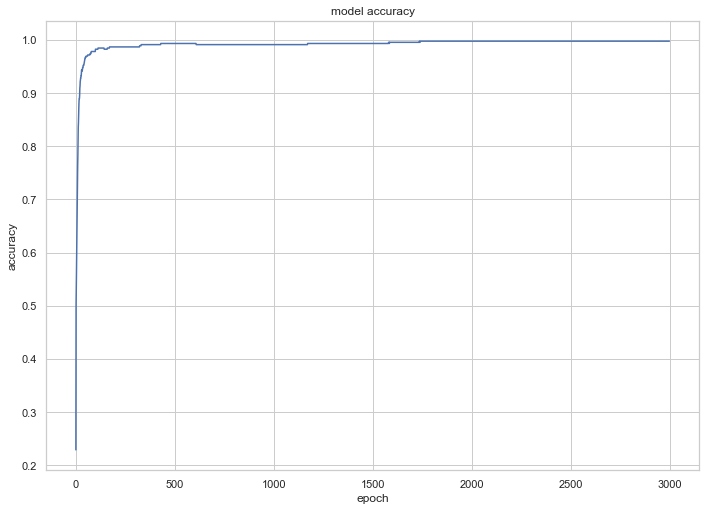

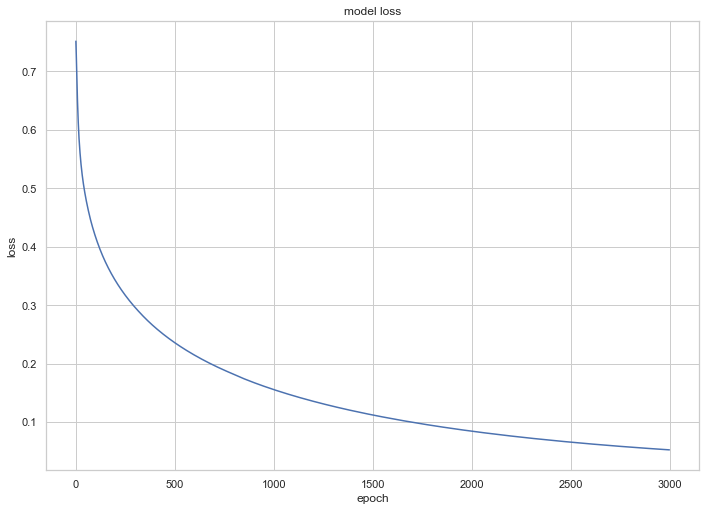

Size: 2289.000000 bits - FPR: 0.037736 



Number of nodes: 3


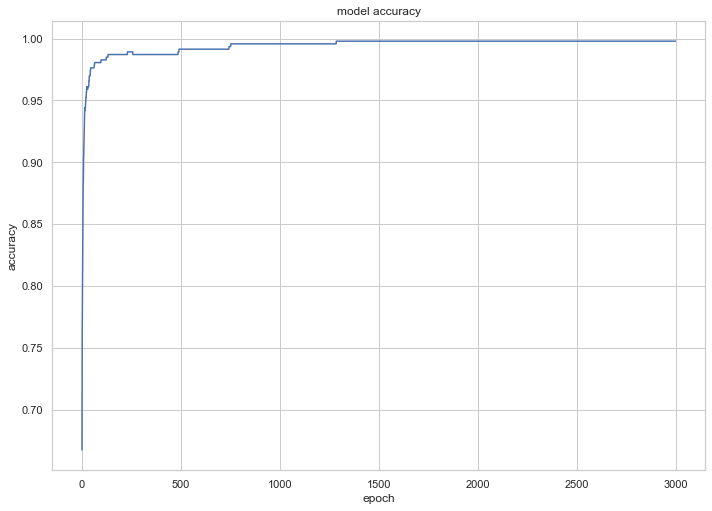

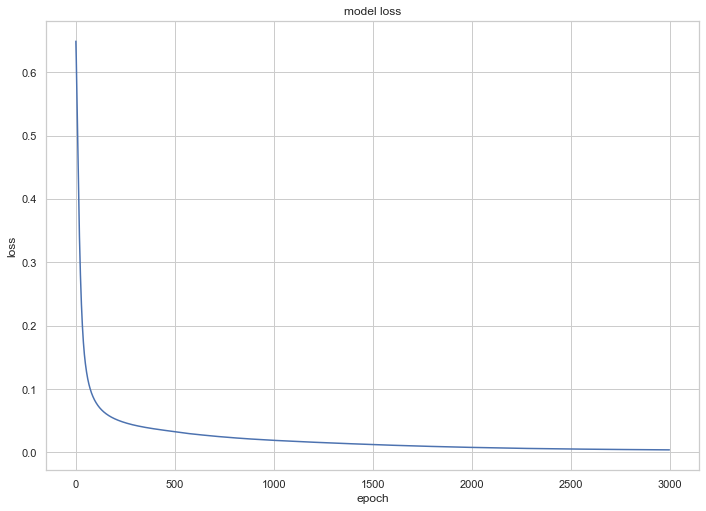

Size: 3415.000000 bits - FPR: 0.037736 



Number of nodes: 4


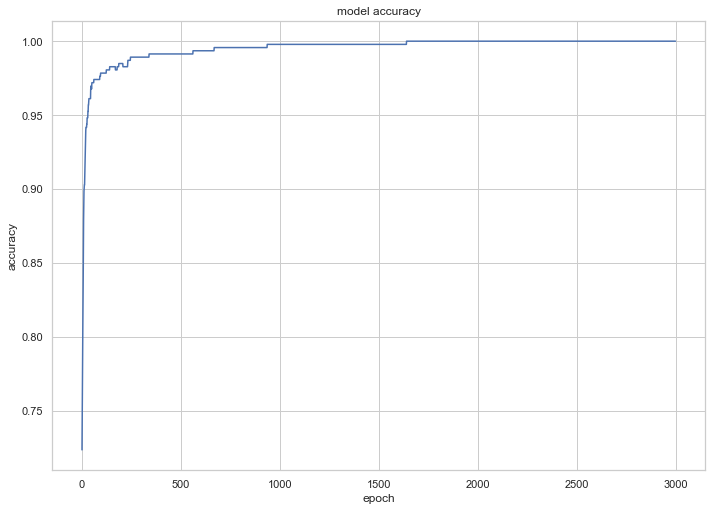

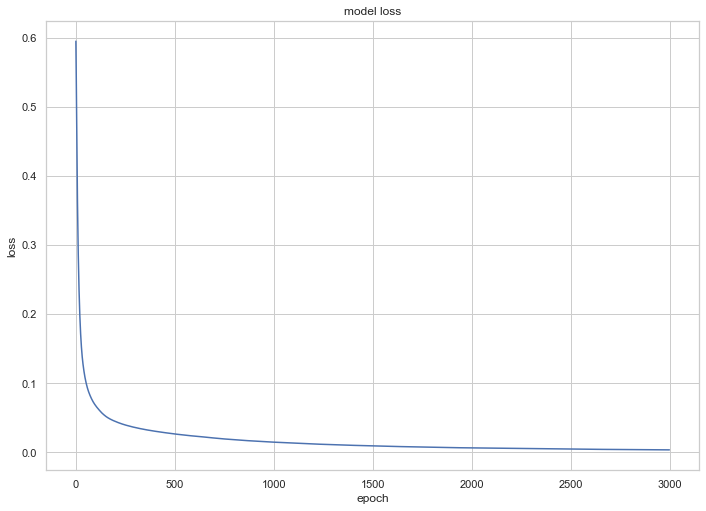

Size: 4541.000000 bits - FPR: 0.037736 



Number of nodes: 5


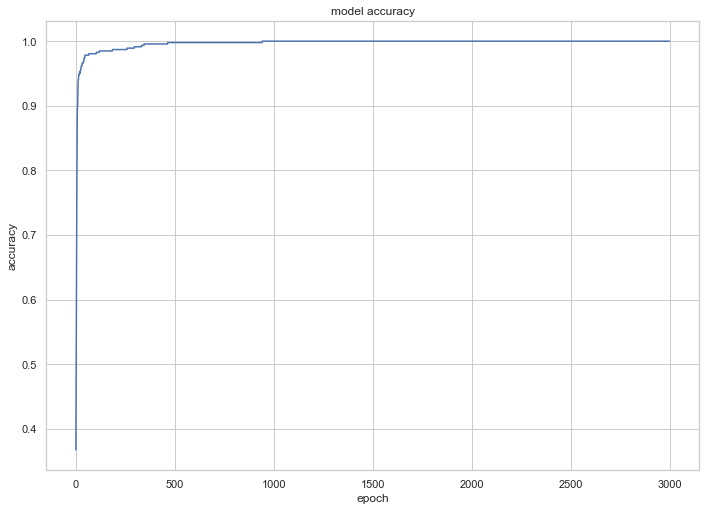

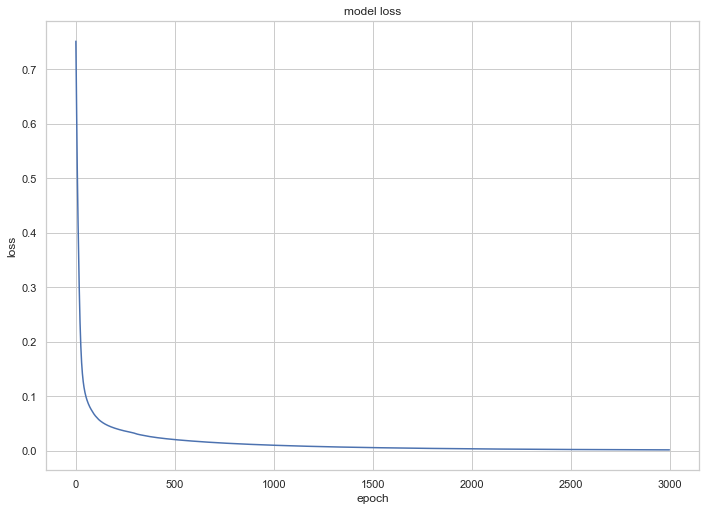

Size: 5668.000000 bits - FPR: 0.037736 



Number of nodes: 6


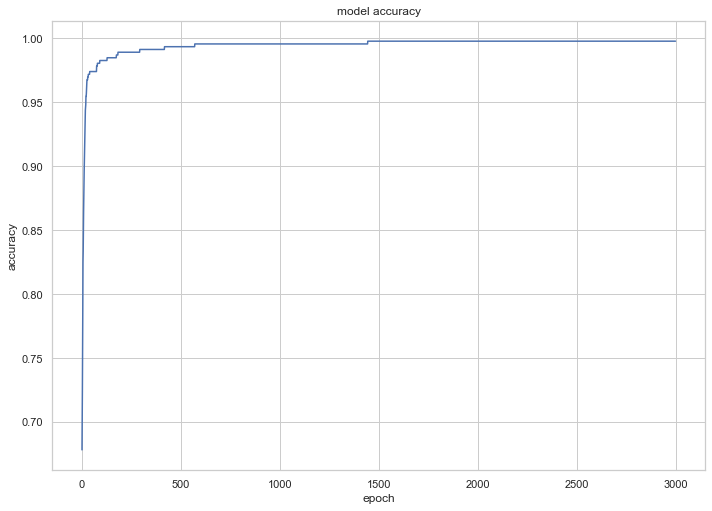

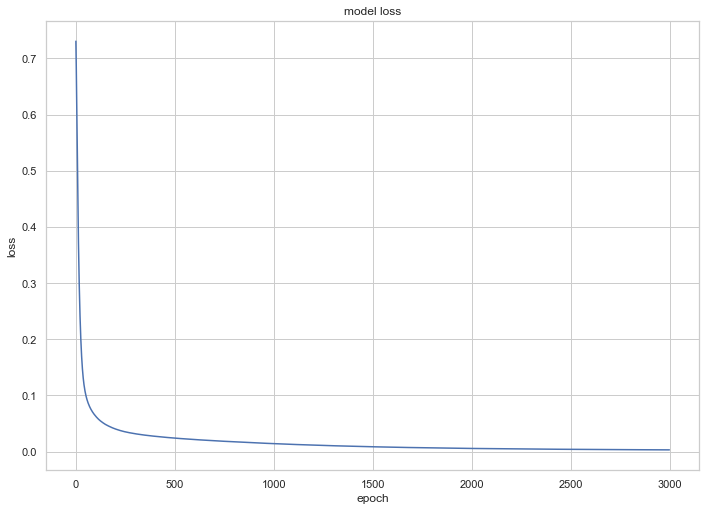

Size: 6794.000000 bits - FPR: 0.047170 



Number of nodes: 7


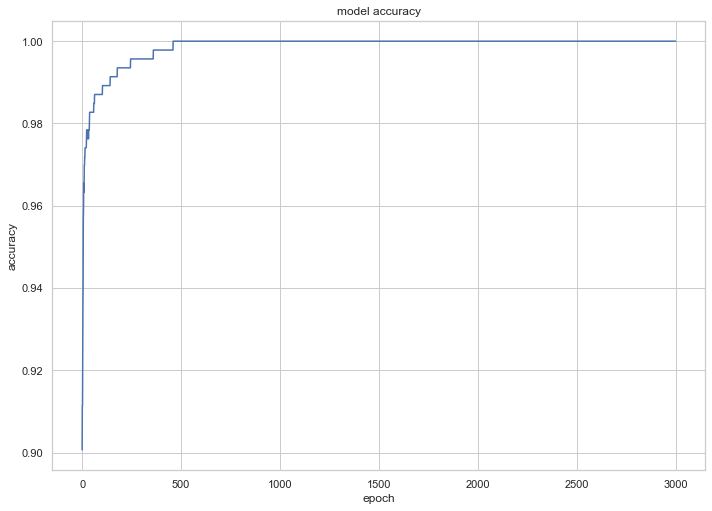

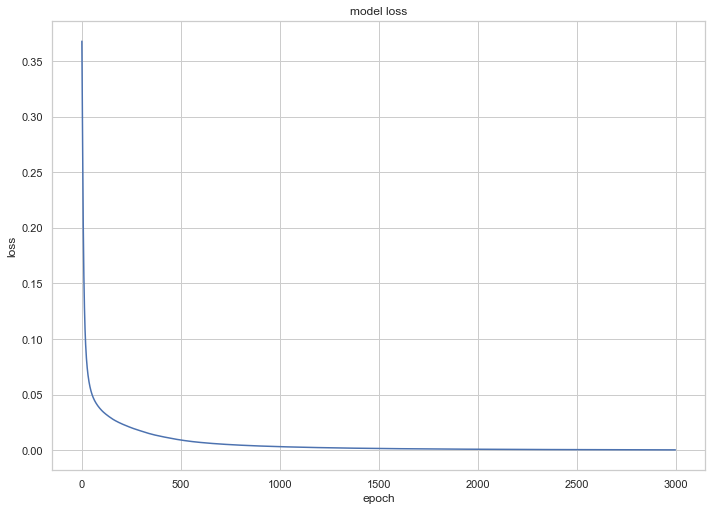

Size: 7921.000000 bits - FPR: 0.047170 



Number of nodes: 8


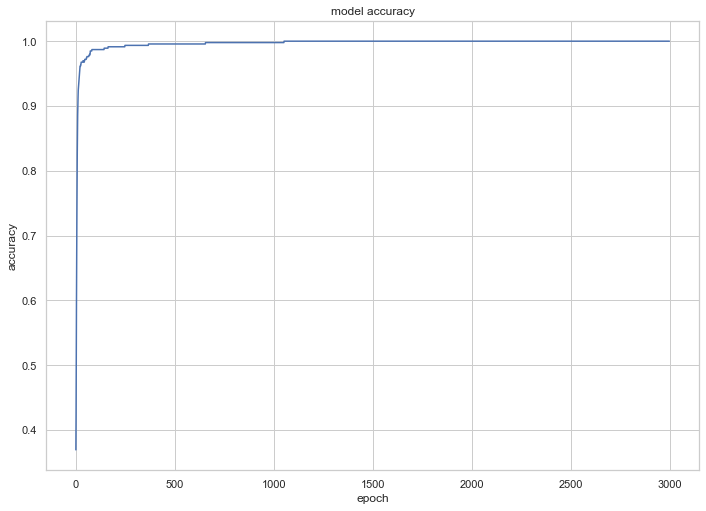

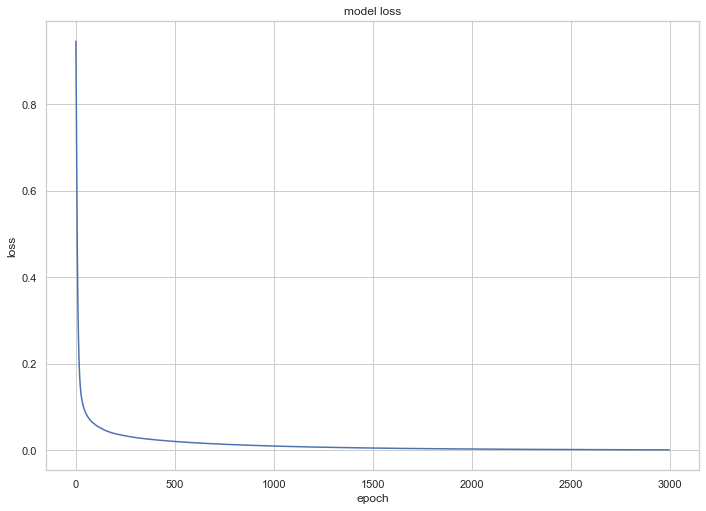

Size: 9047.000000 bits - FPR: 0.037736 



Number of nodes: 9


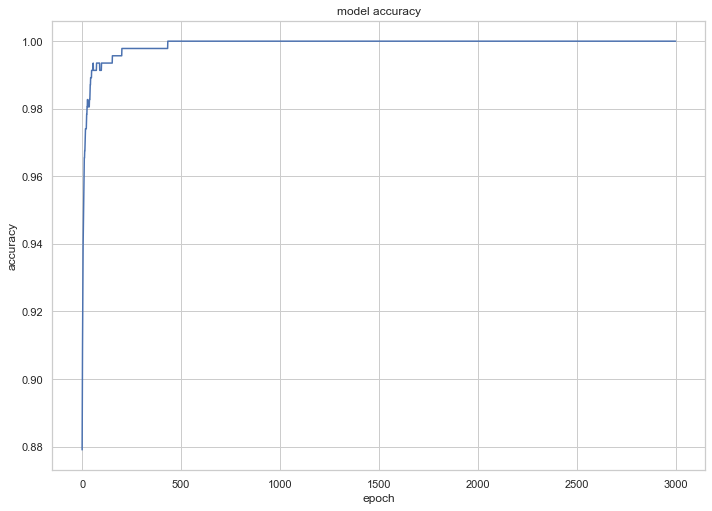

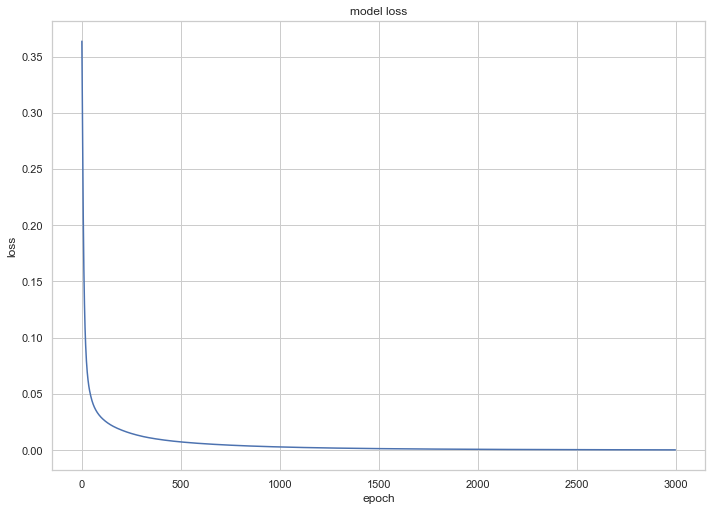

Size: 10173.000000 bits - FPR: 0.056604 



Number of nodes: 10


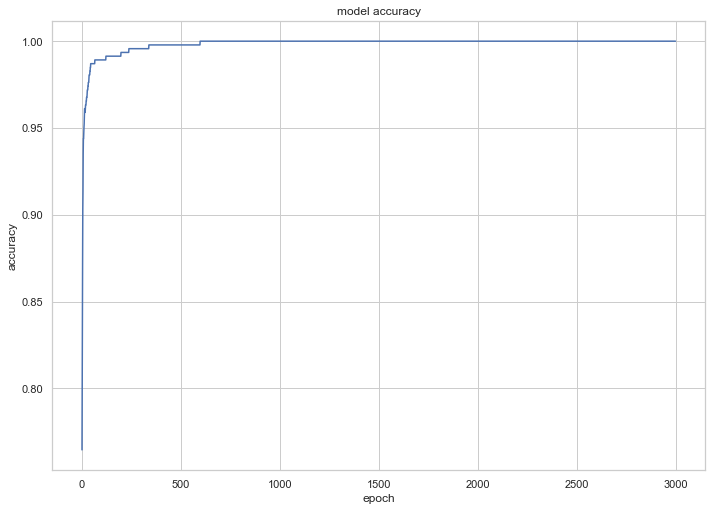

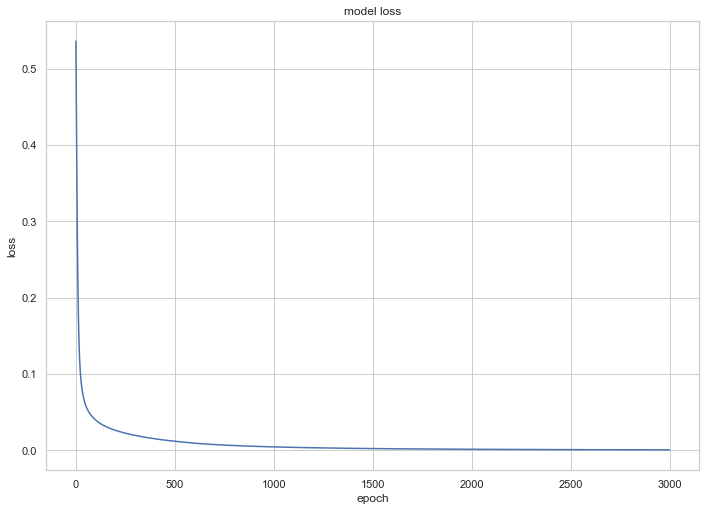

Size: 11300.000000 bits - FPR: 0.056604 



Number of nodes: 11


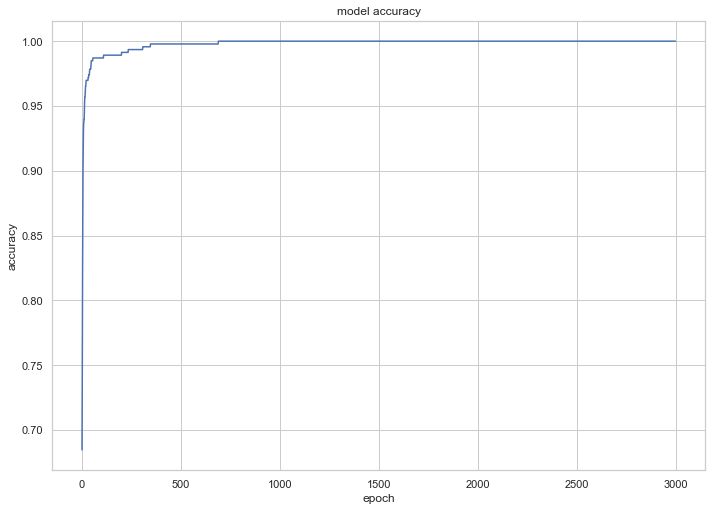

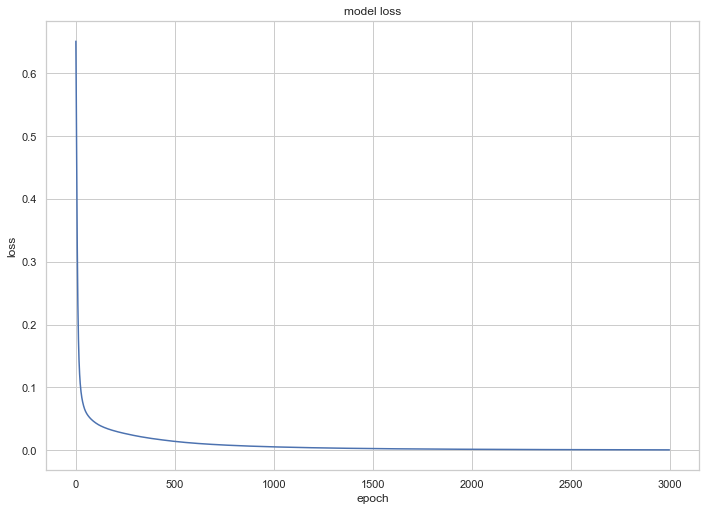

Size: 12426.000000 bits - FPR: 0.047170 



Number of nodes: 12


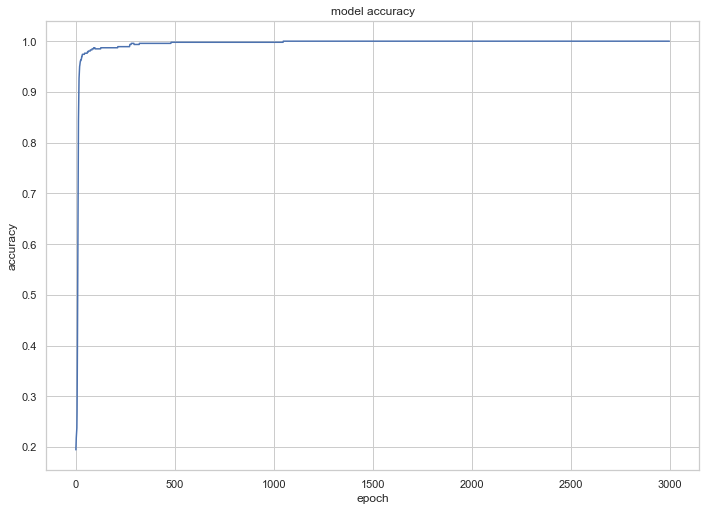

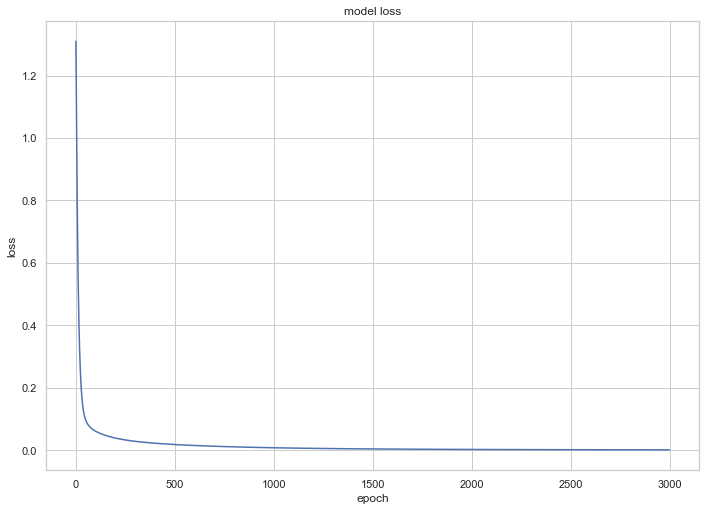

Size: 13553.000000 bits - FPR: 0.037736 



Number of nodes: 13


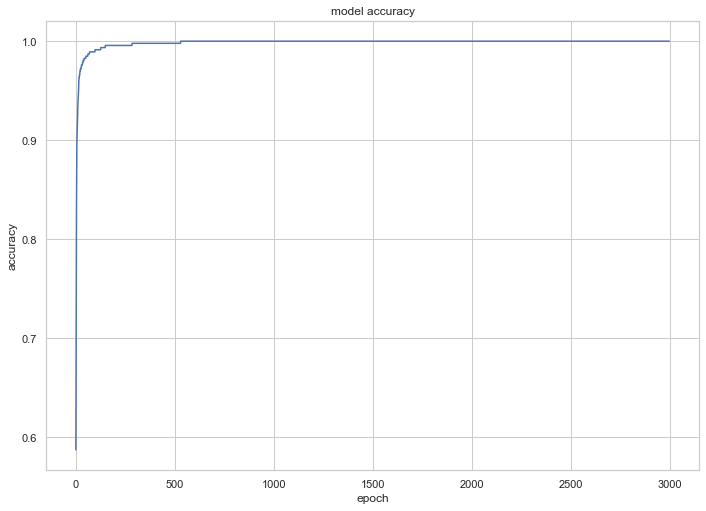

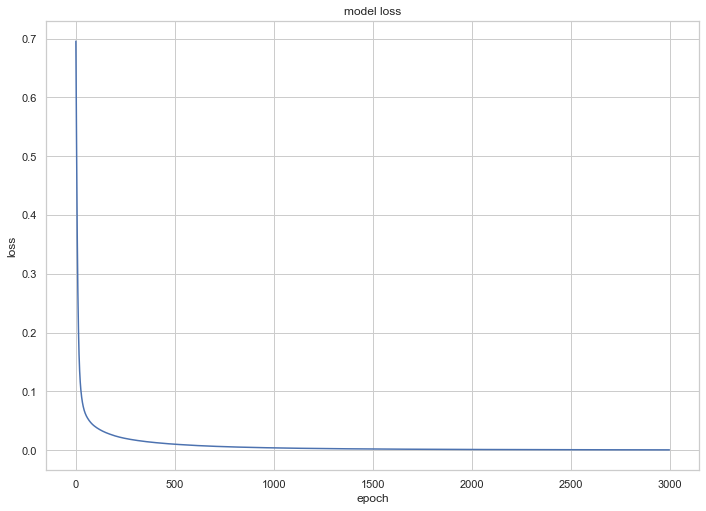

Size: 14679.000000 bits - FPR: 0.037736 



Number of nodes: 14


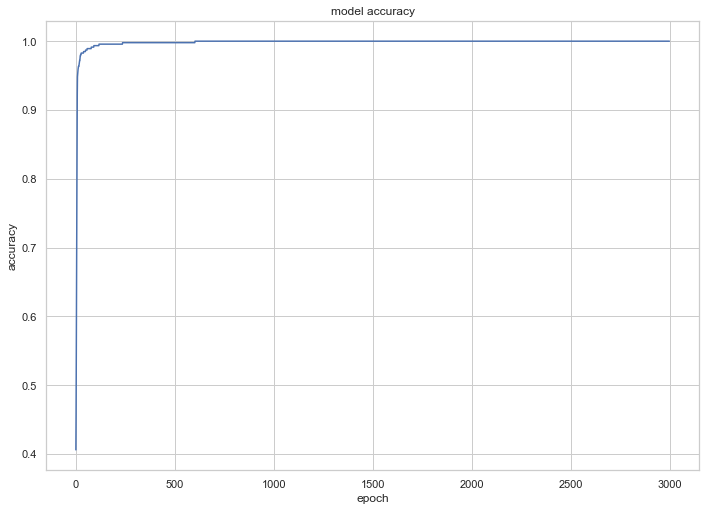

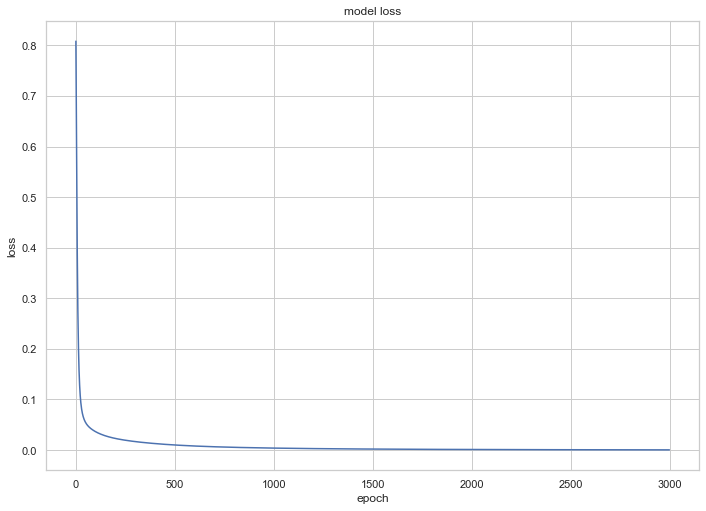

Size: 15805.000000 bits - FPR: 0.047170 



Number of nodes: 15


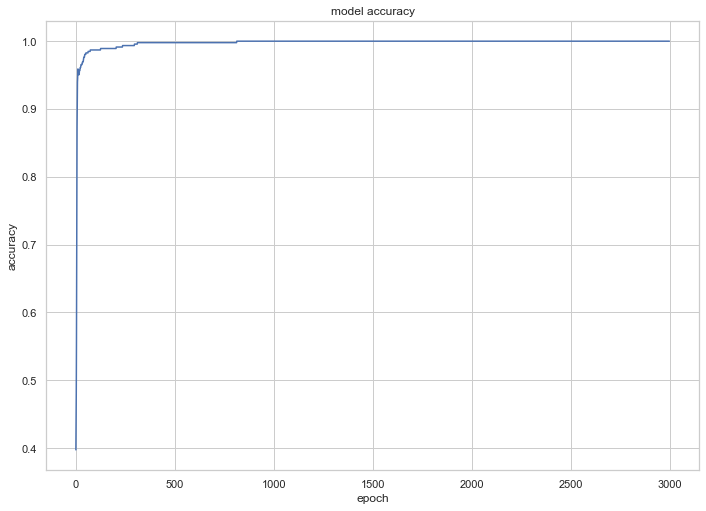

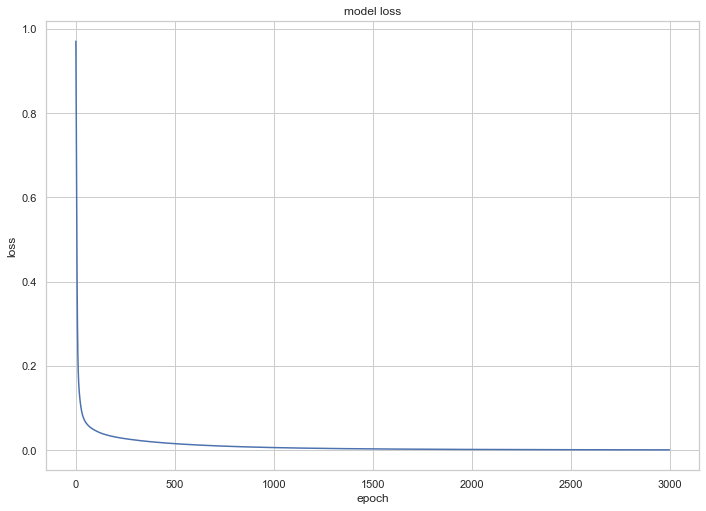

Size: 16932.000000 bits - FPR: 0.037736 



Number of nodes: 16


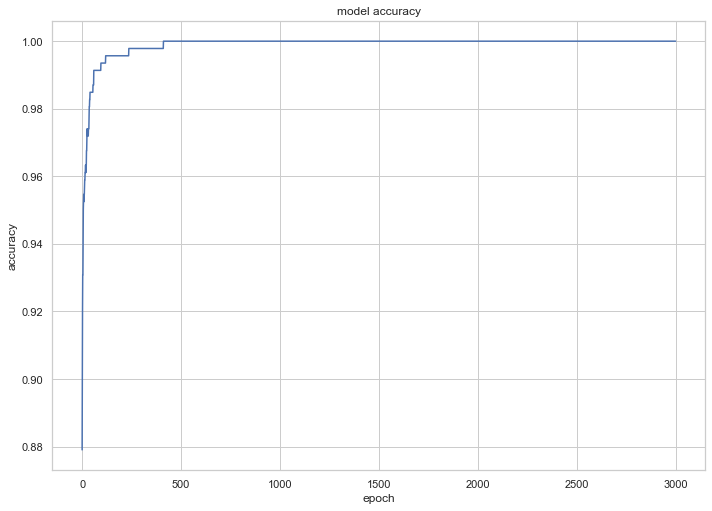

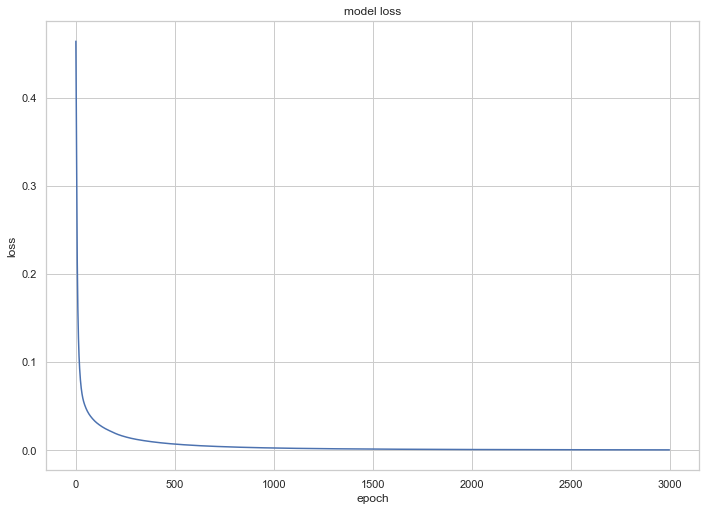

Size: 18058.000000 bits - FPR: 0.056604 



Number of nodes: 17


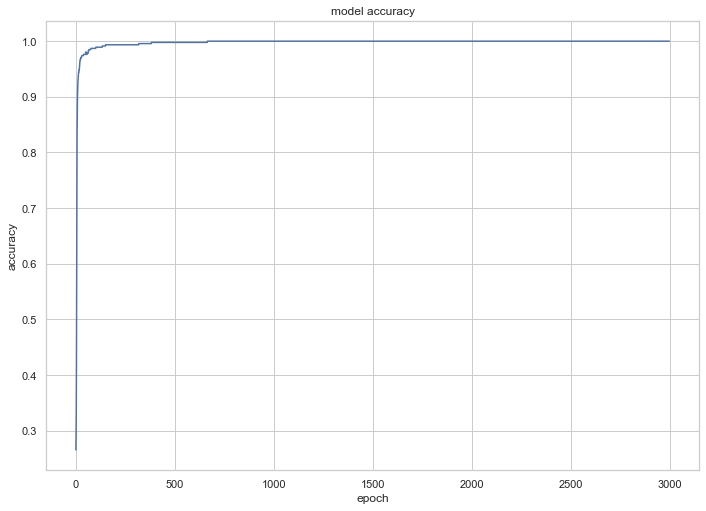

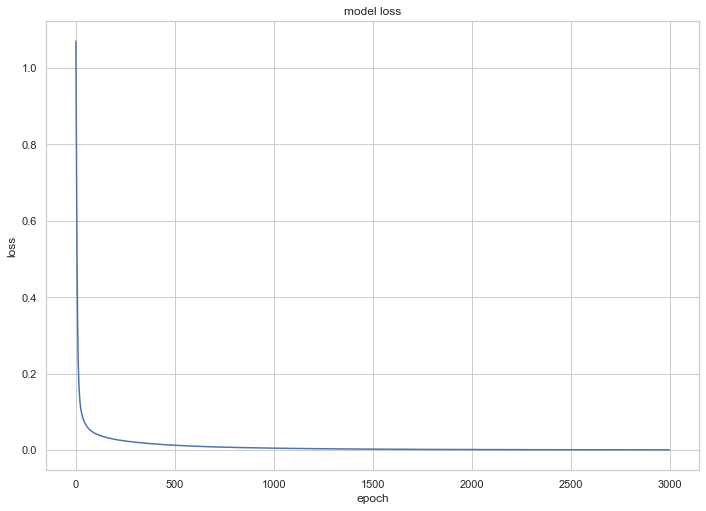

Size: 19185.000000 bits - FPR: 0.018868 



Number of nodes: 18


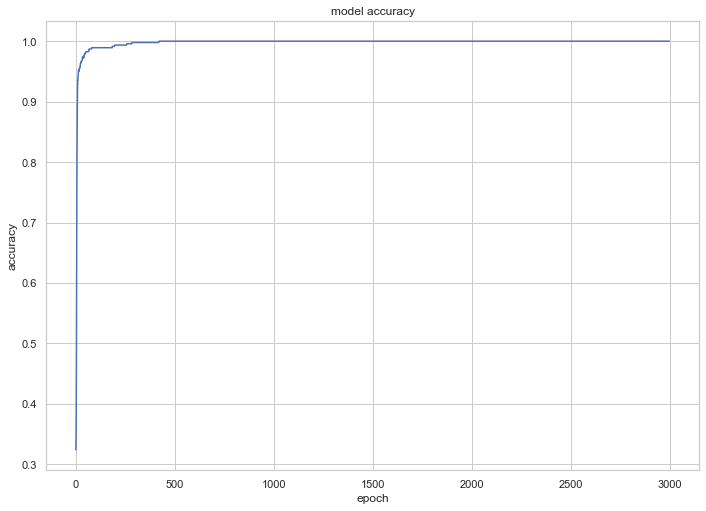

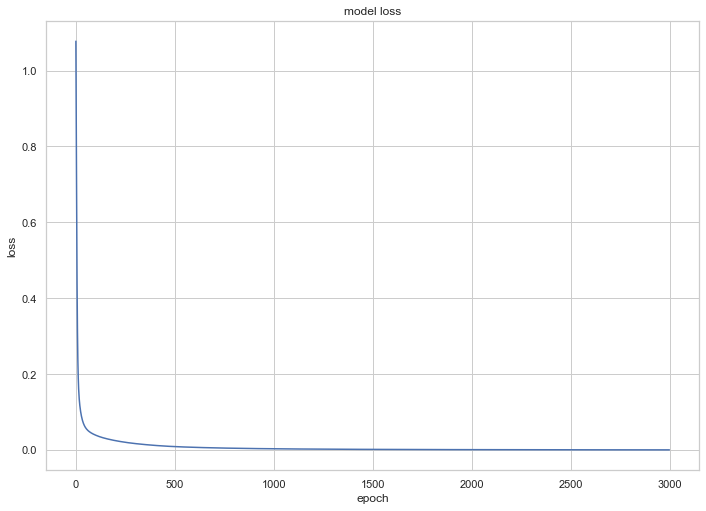

Size: 20311.000000 bits - FPR: 0.037736 



Number of nodes: 19


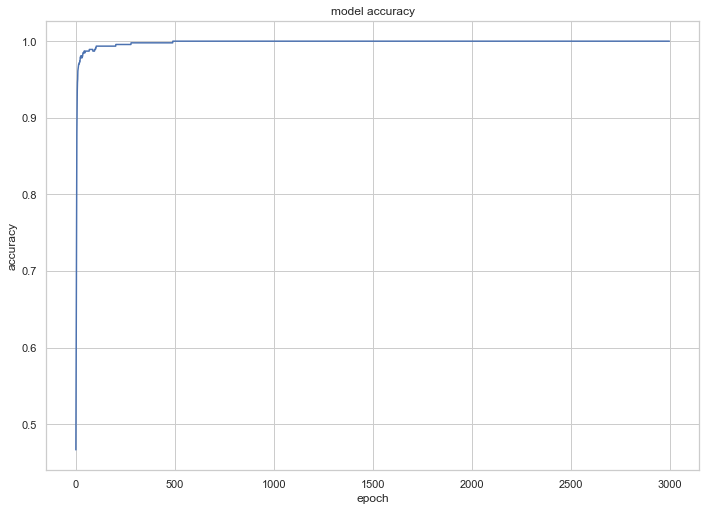

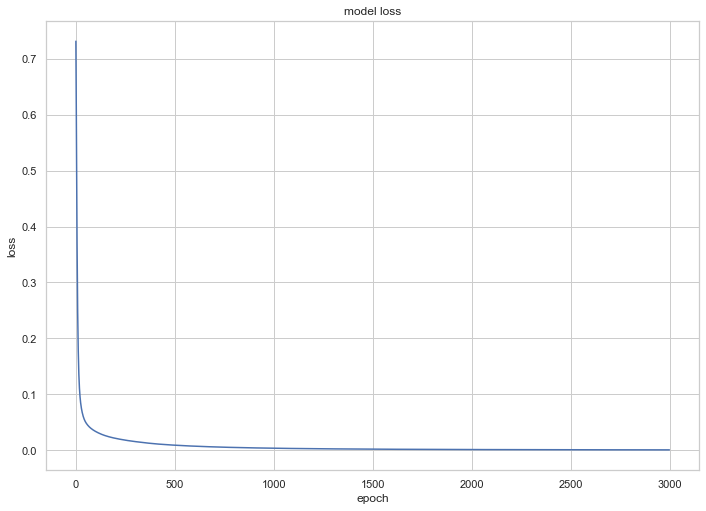

Size: 21437.000000 bits - FPR: 0.037736 



Number of nodes: 20


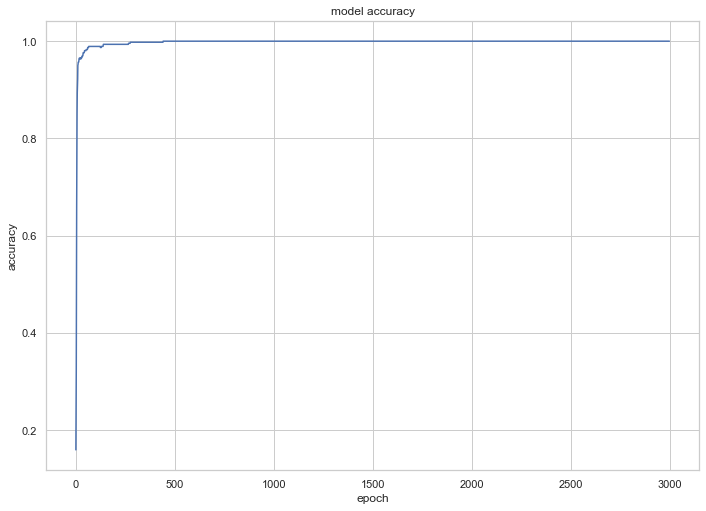

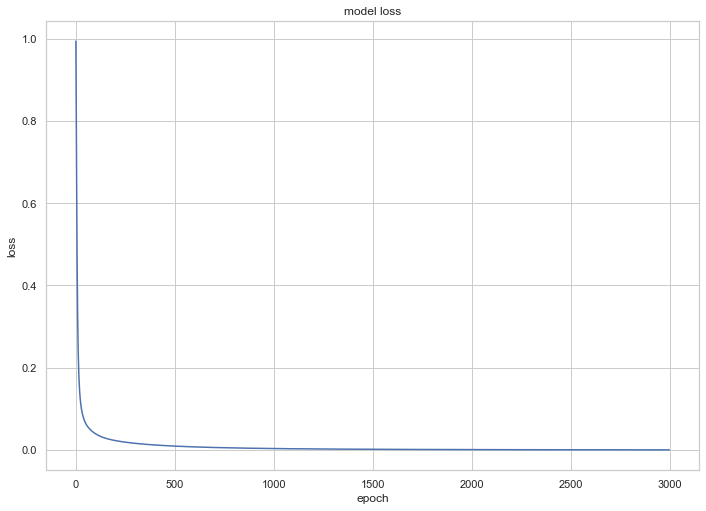

Size: 22564.000000 bits - FPR: 0.047170 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 1


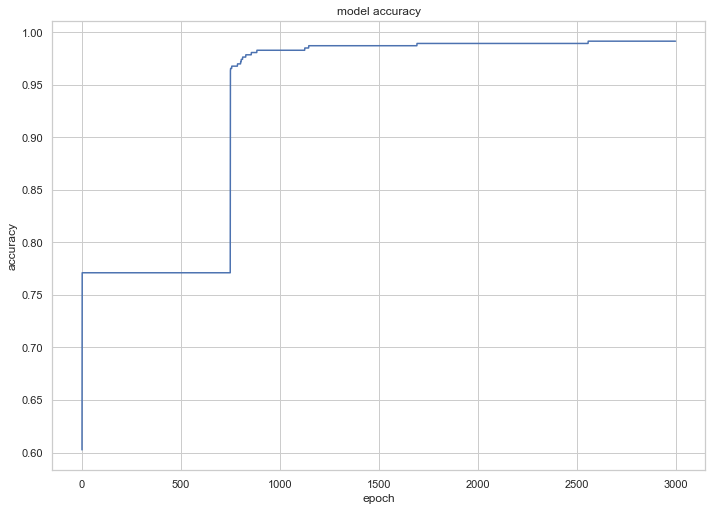

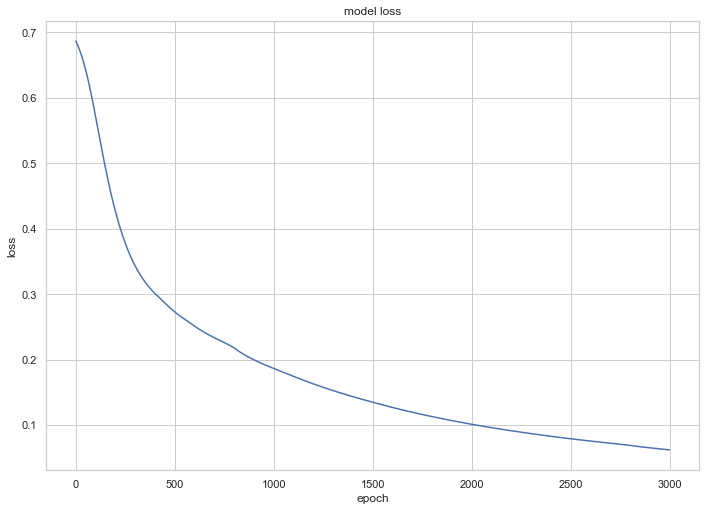

Size: 1162.000000 bits - FPR: 0.028302 



Number of nodes: 2


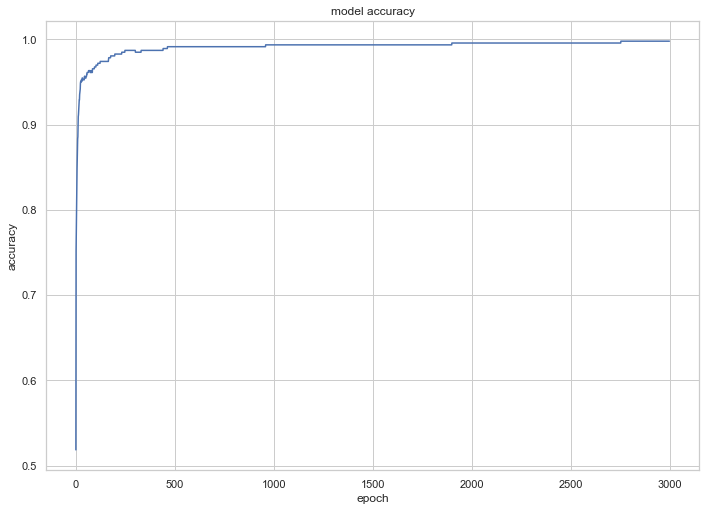

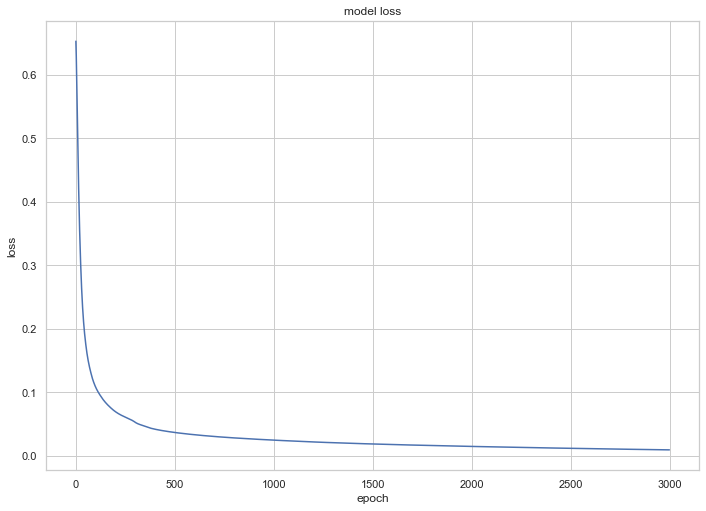

Size: 2289.000000 bits - FPR: 0.037736 



Number of nodes: 3


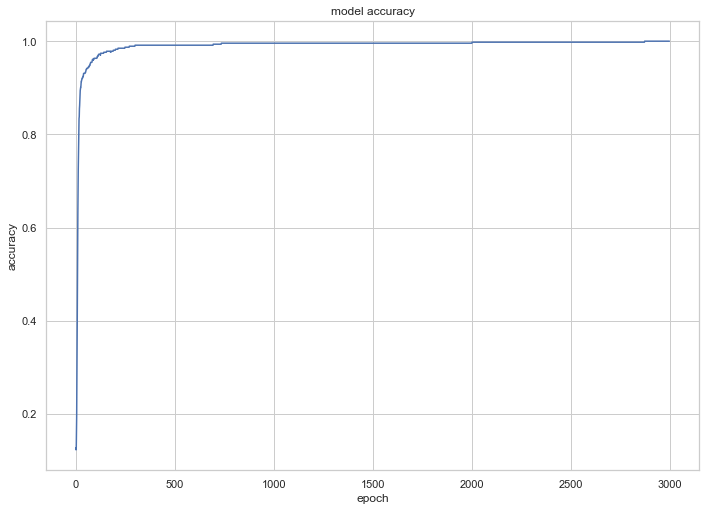

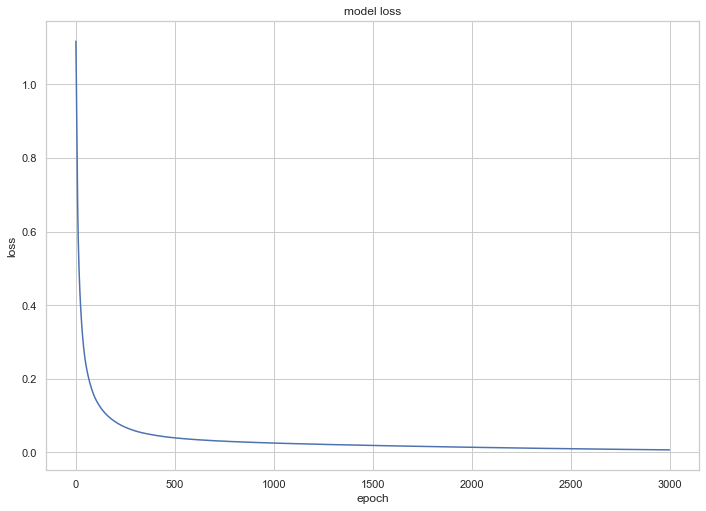

Size: 3415.000000 bits - FPR: 0.047170 



Number of nodes: 4


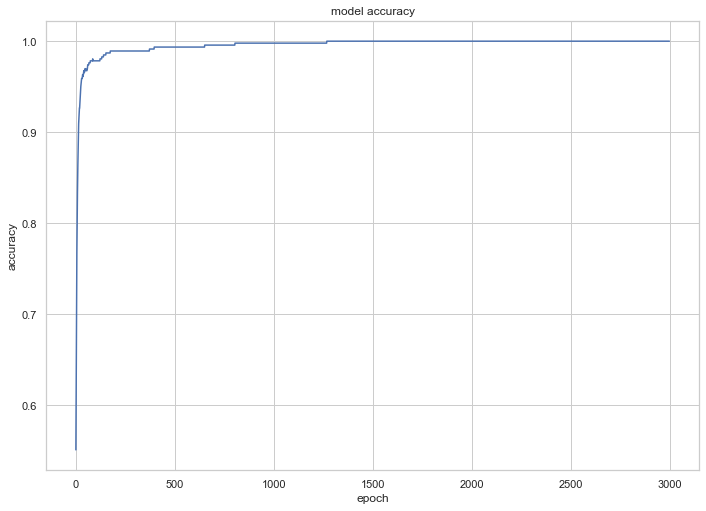

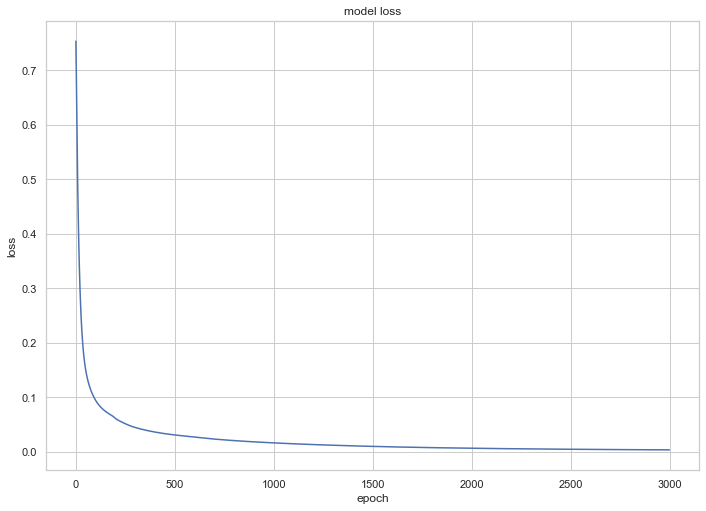

Size: 4541.000000 bits - FPR: 0.037736 



Number of nodes: 5


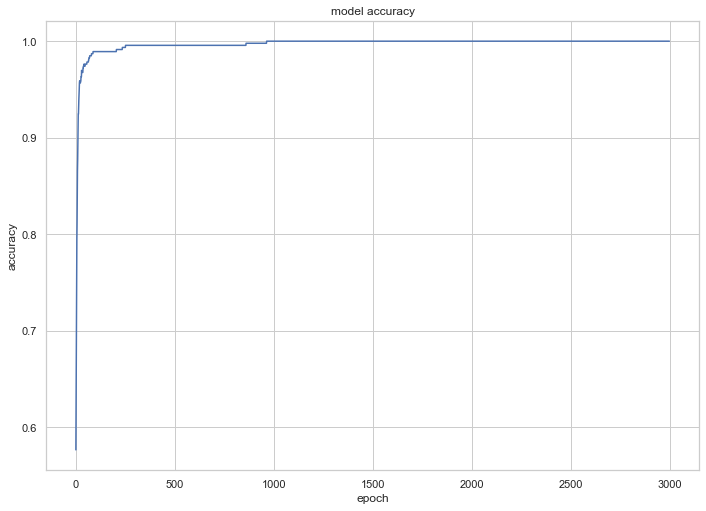

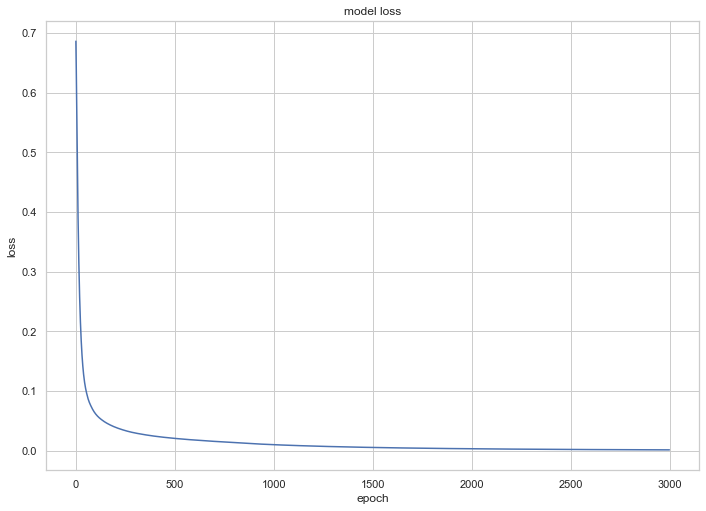

Size: 5668.000000 bits - FPR: 0.037736 



Number of nodes: 6


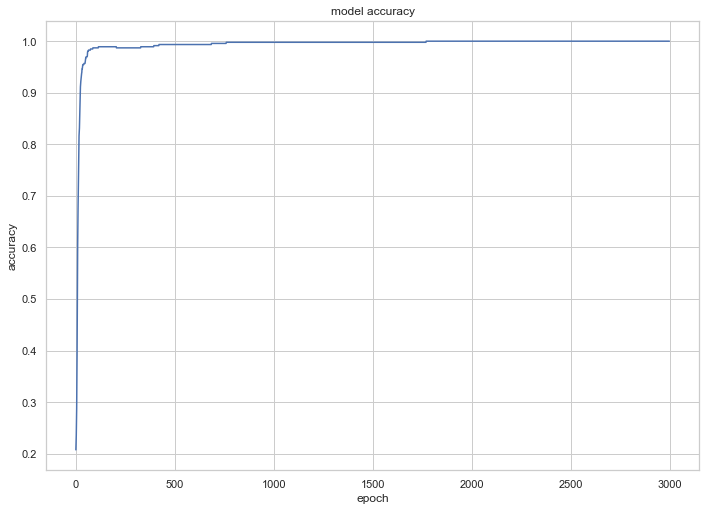

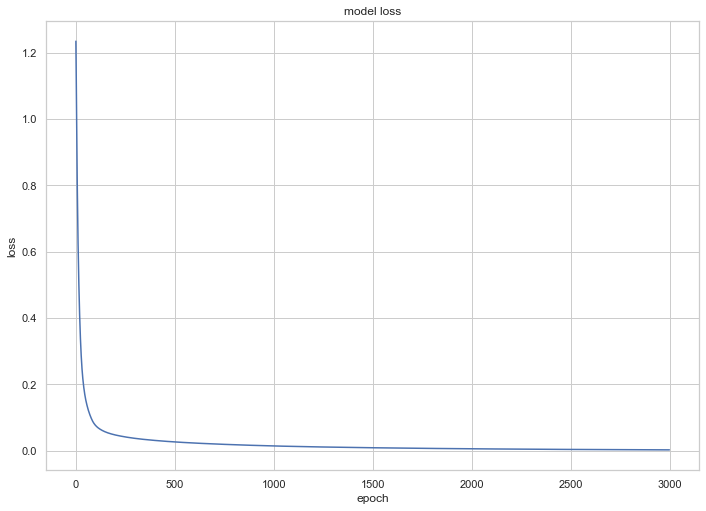

Size: 6794.000000 bits - FPR: 0.037736 



Number of nodes: 7


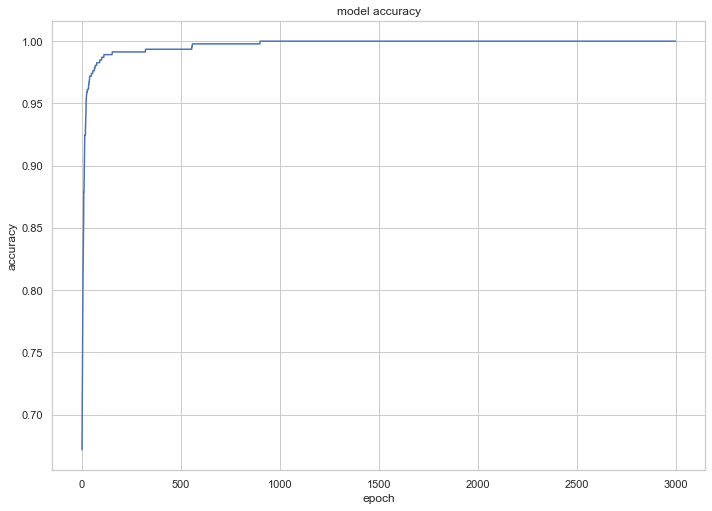

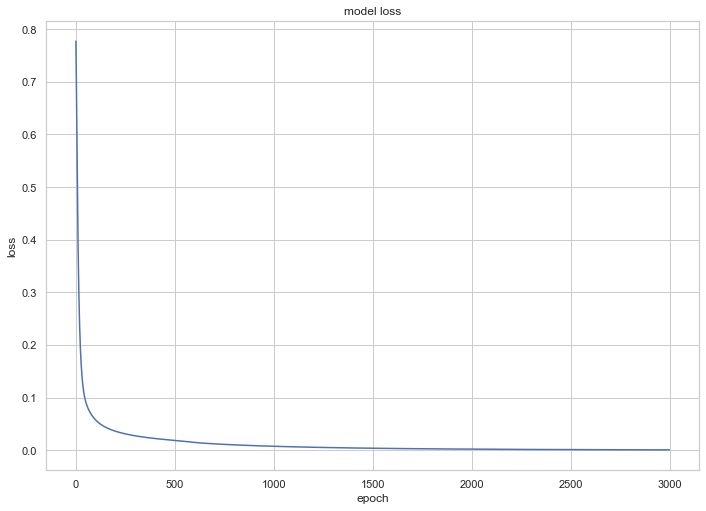

Size: 7921.000000 bits - FPR: 0.047170 



Number of nodes: 8


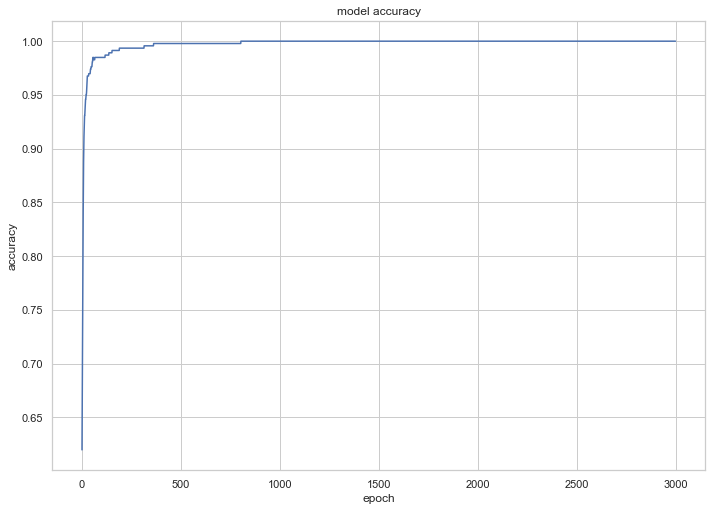

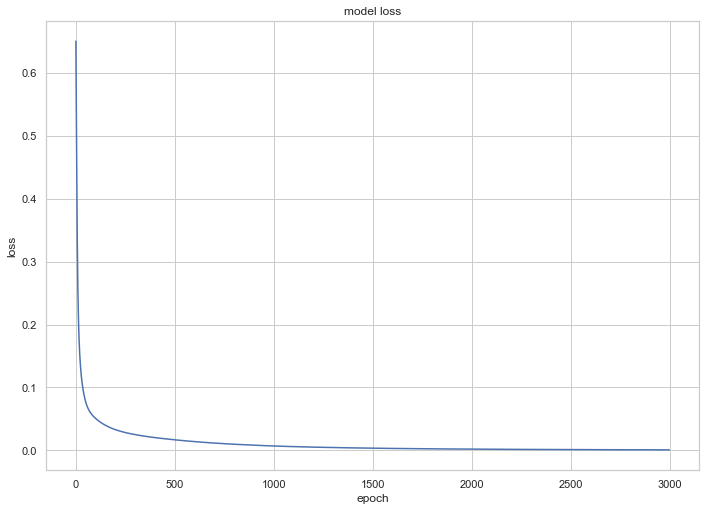

Size: 9047.000000 bits - FPR: 0.056604 



Number of nodes: 9


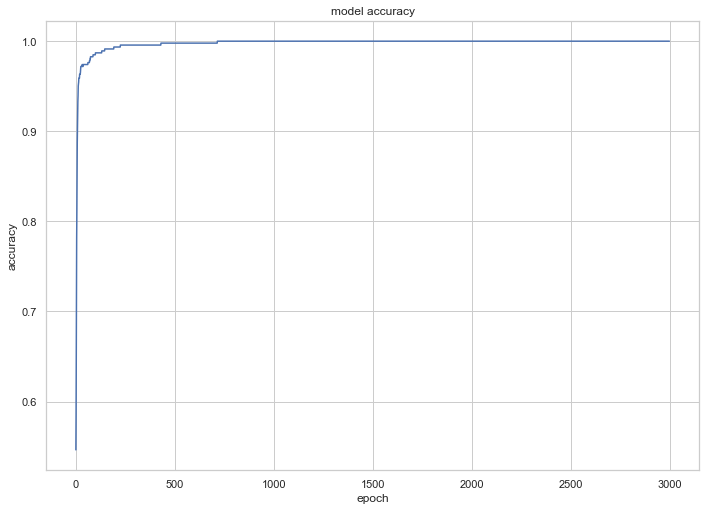

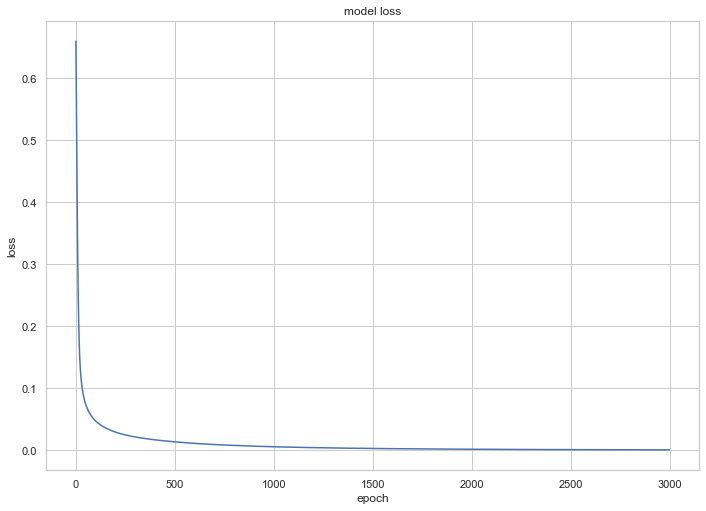

Size: 10173.000000 bits - FPR: 0.037736 



Number of nodes: 10


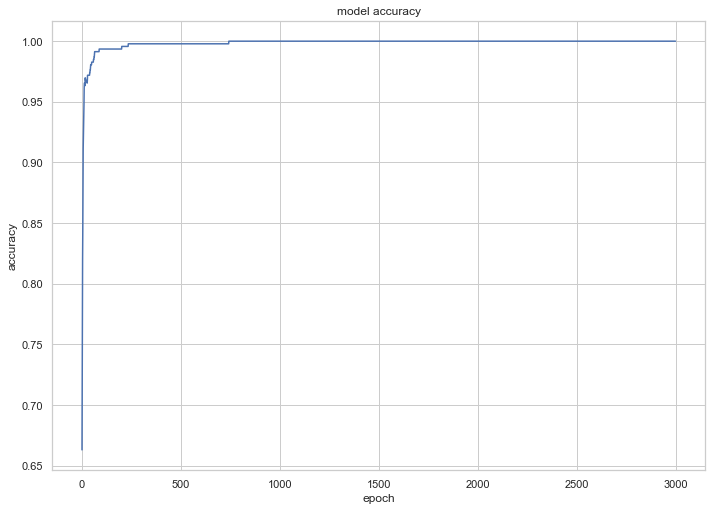

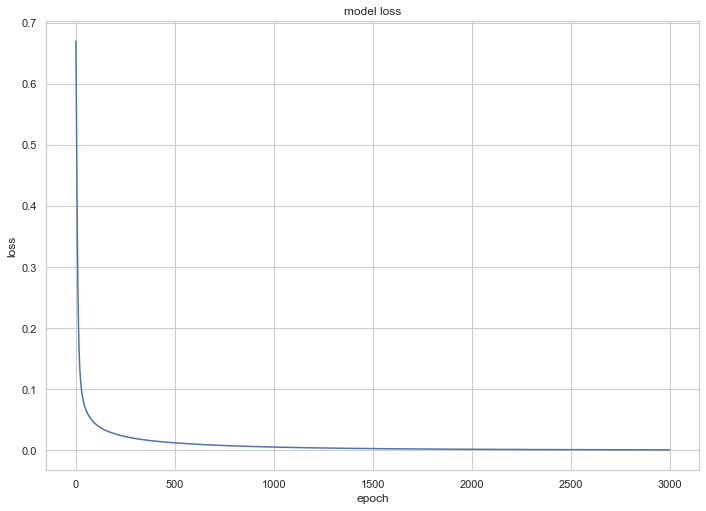

Size: 11300.000000 bits - FPR: 0.037736 



Number of nodes: 11


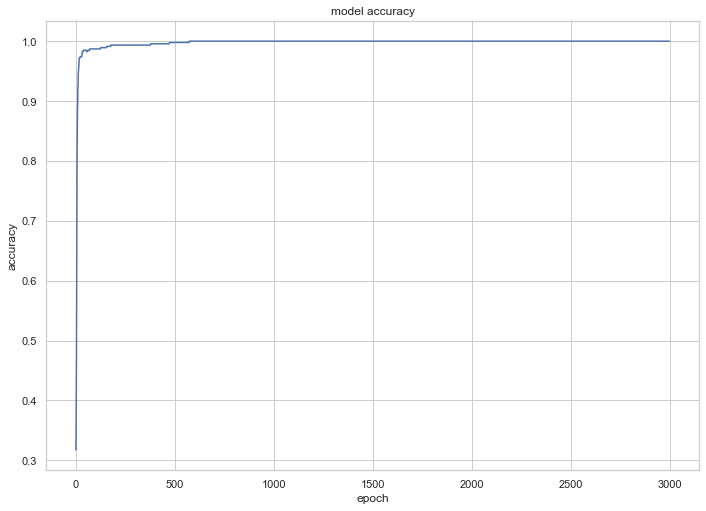

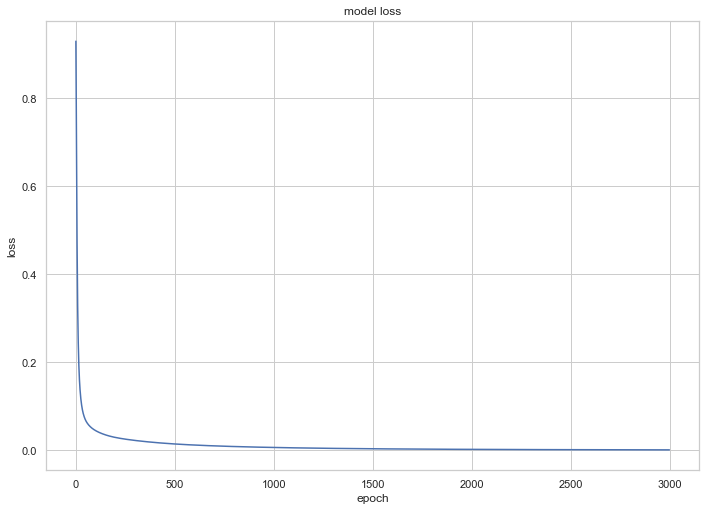

Size: 12426.000000 bits - FPR: 0.037736 



Number of nodes: 12


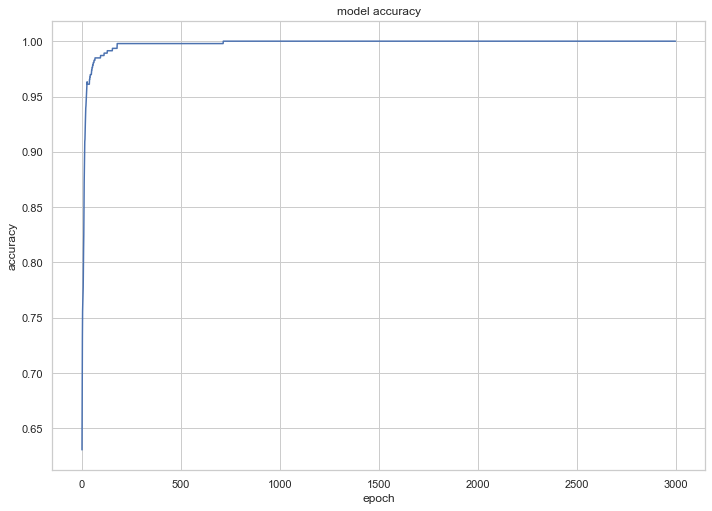

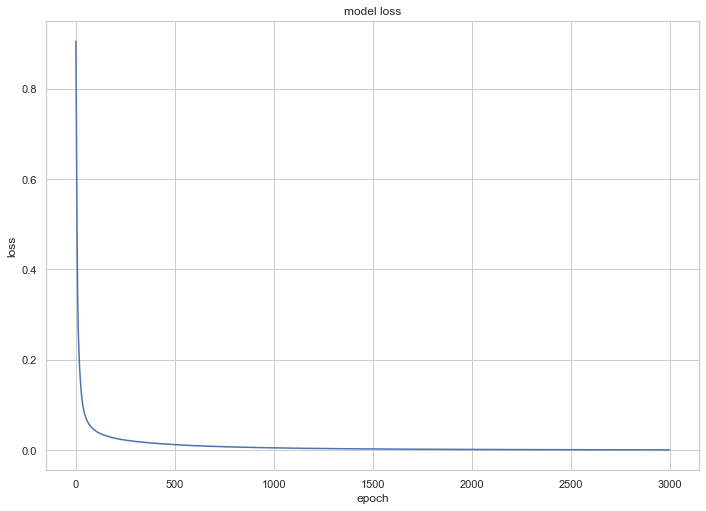

Size: 13553.000000 bits - FPR: 0.047170 



Number of nodes: 13


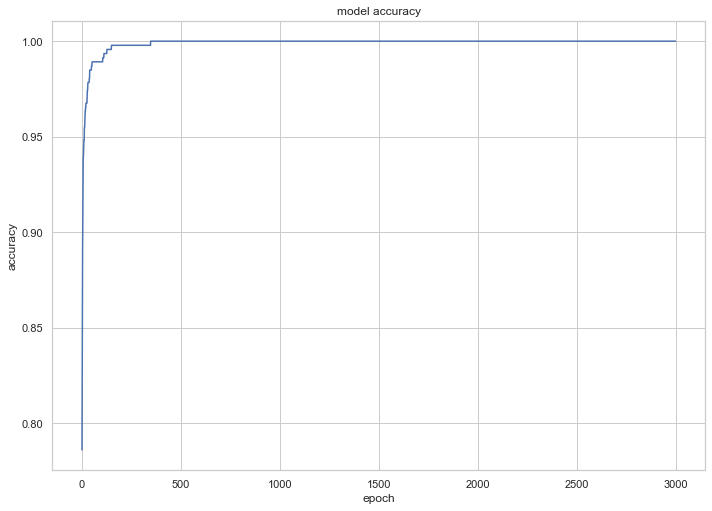

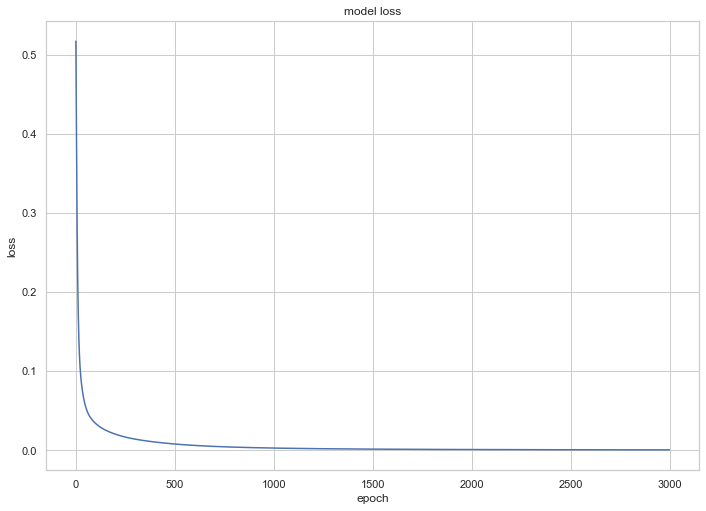

Size: 14679.000000 bits - FPR: 0.037736 



Number of nodes: 14


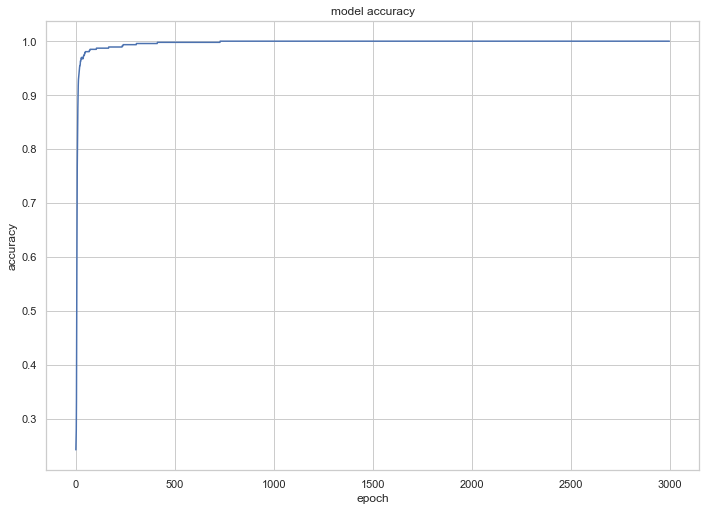

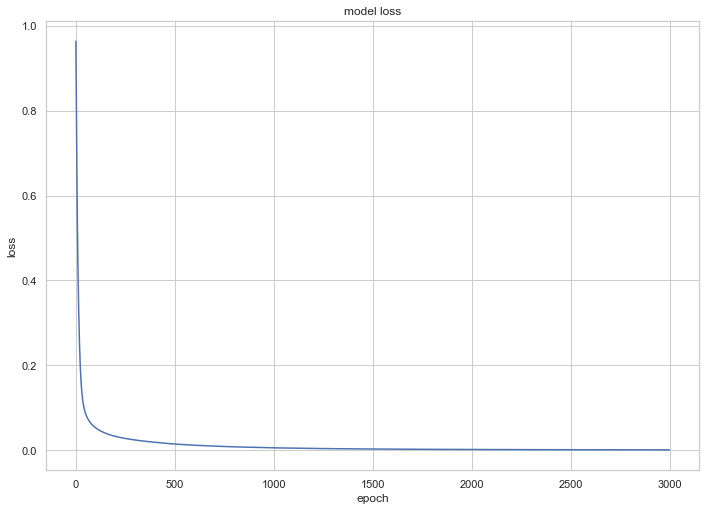

Size: 15805.000000 bits - FPR: 0.028302 



Number of nodes: 15


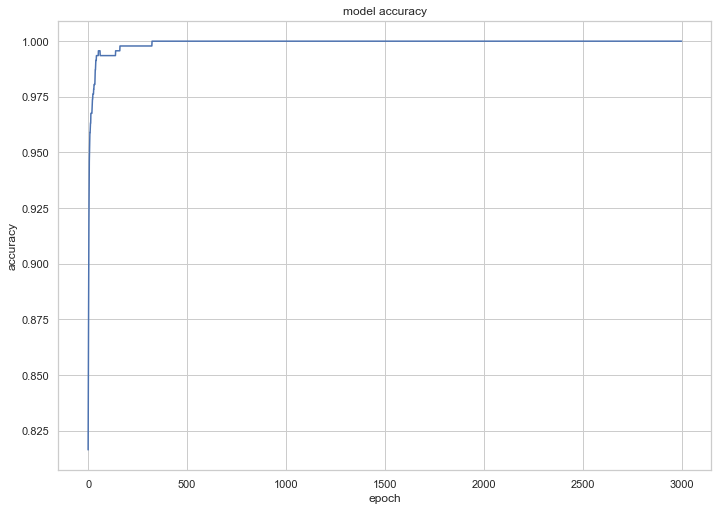

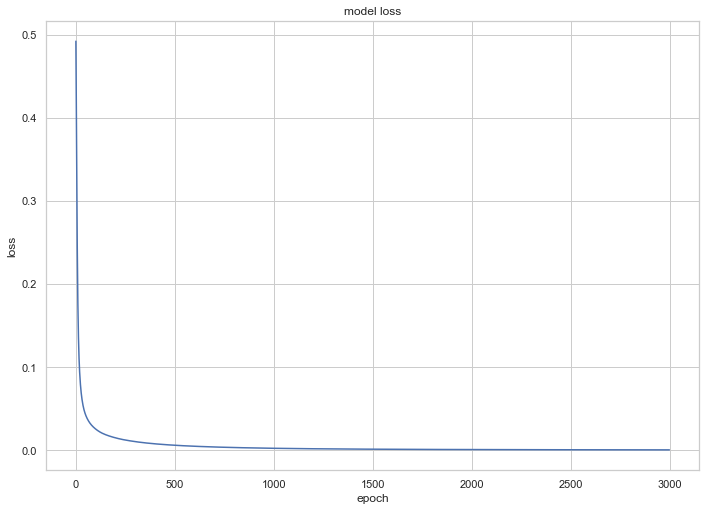

Size: 16932.000000 bits - FPR: 0.056604 



Number of nodes: 16


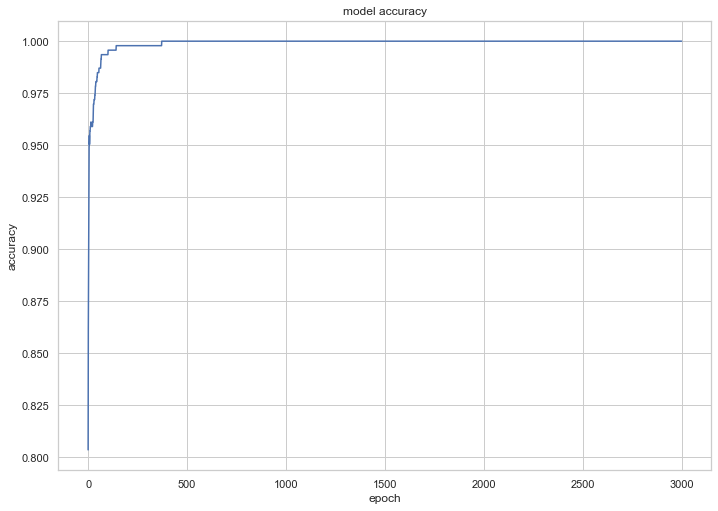

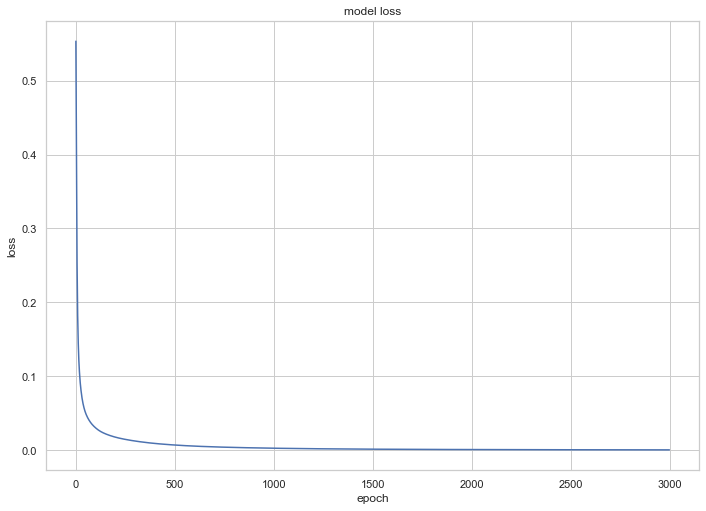

Size: 18058.000000 bits - FPR: 0.047170 



Number of nodes: 17


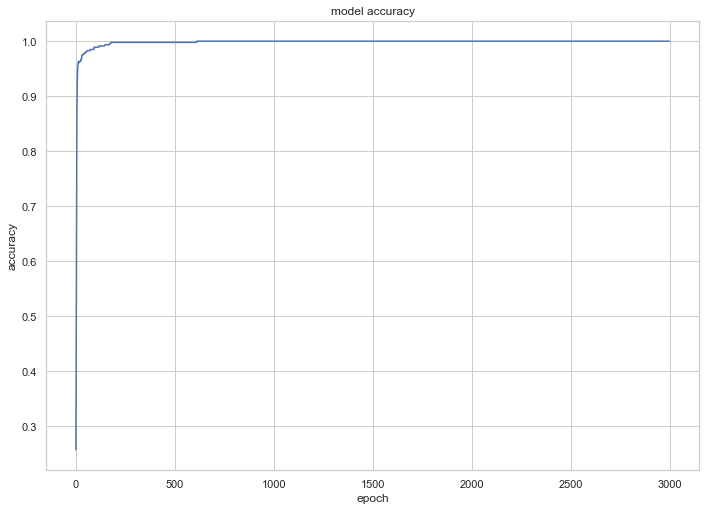

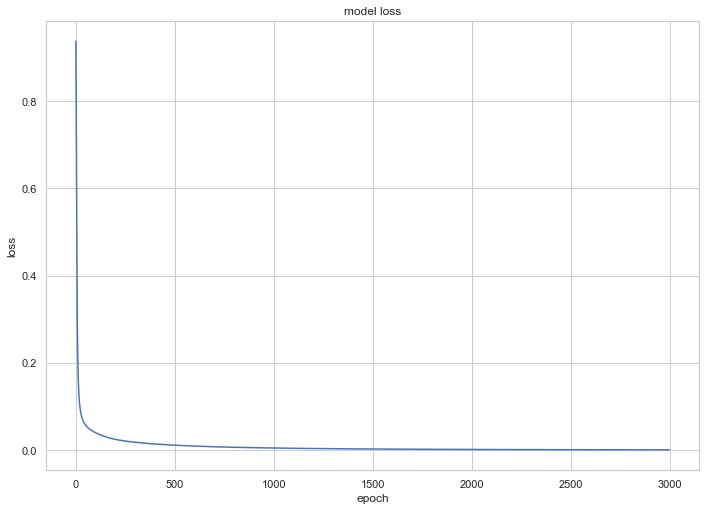

Size: 19185.000000 bits - FPR: 0.028302 



Number of nodes: 18


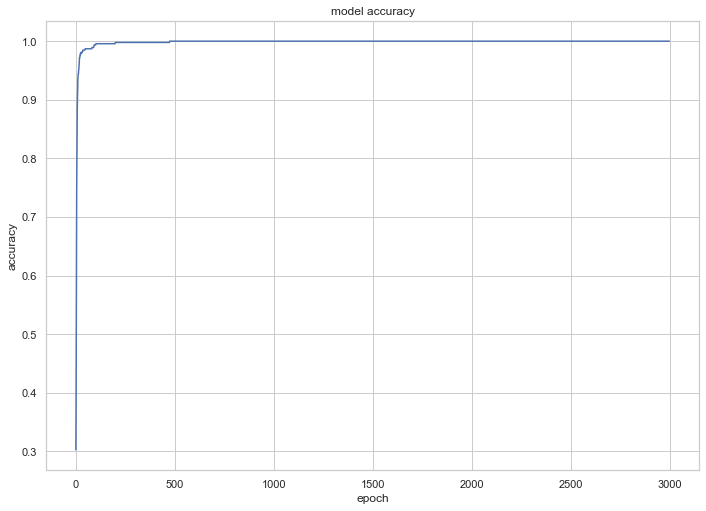

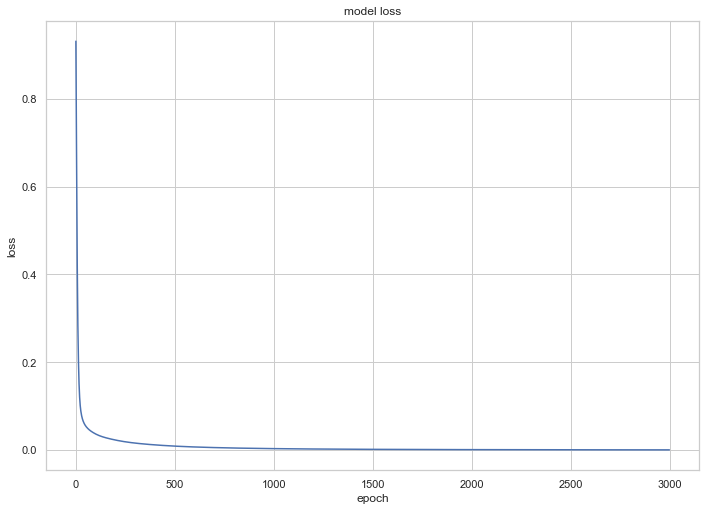

Size: 20311.000000 bits - FPR: 0.037736 



Number of nodes: 19


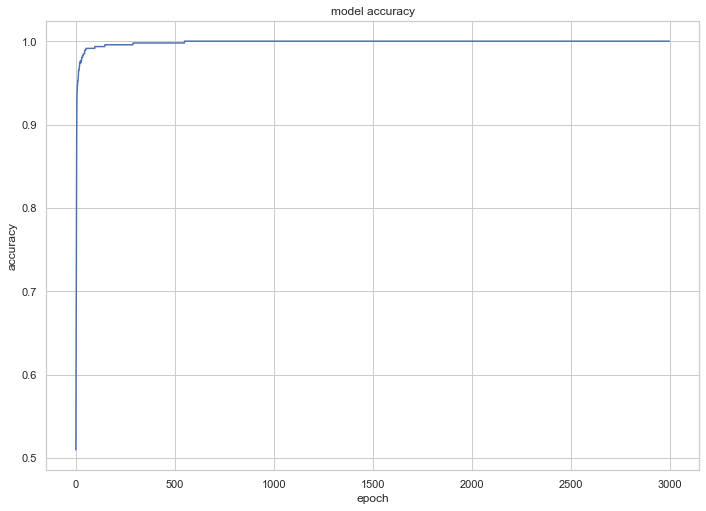

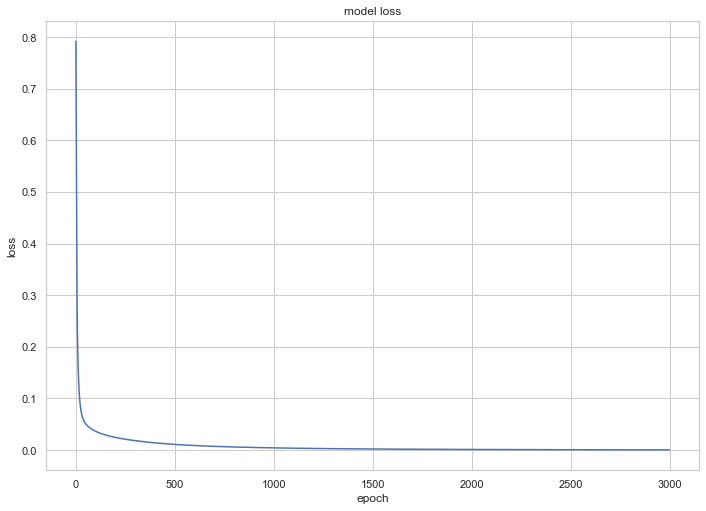

Size: 21437.000000 bits - FPR: 0.047170 



Number of nodes: 20


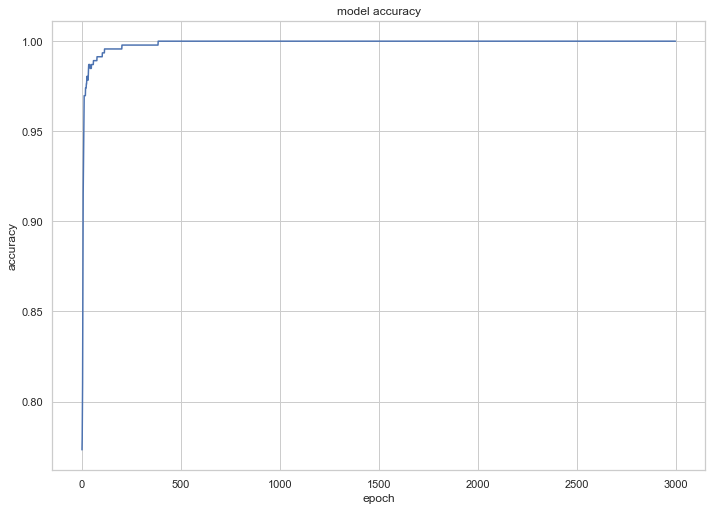

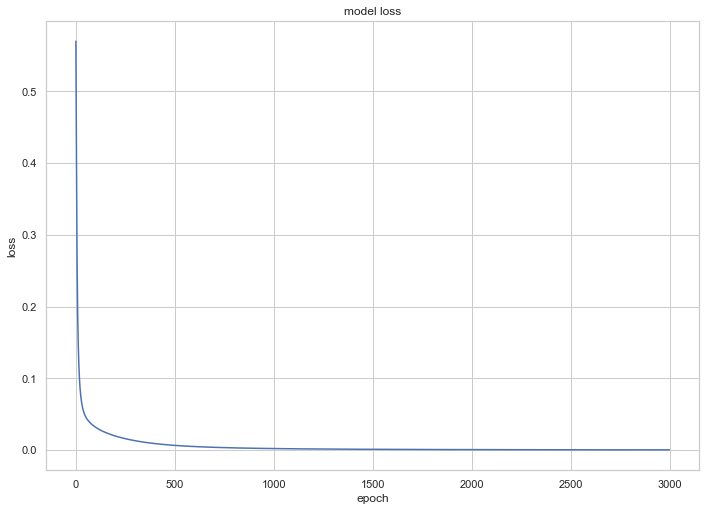

Size: 22564.000000 bits - FPR: 0.037736 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 1


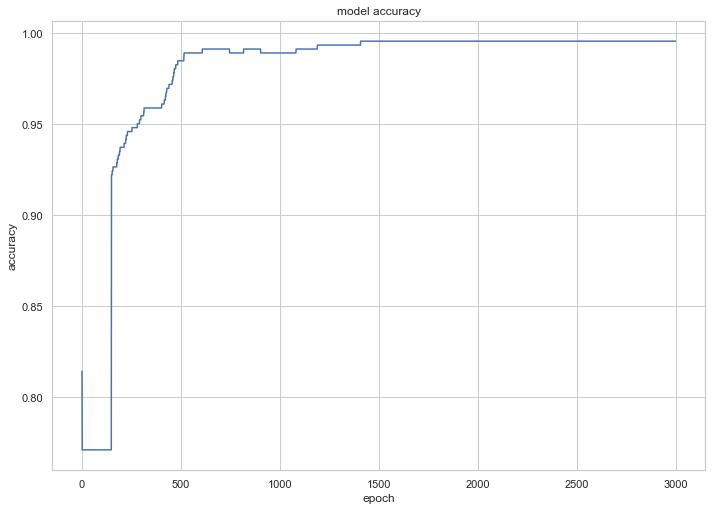

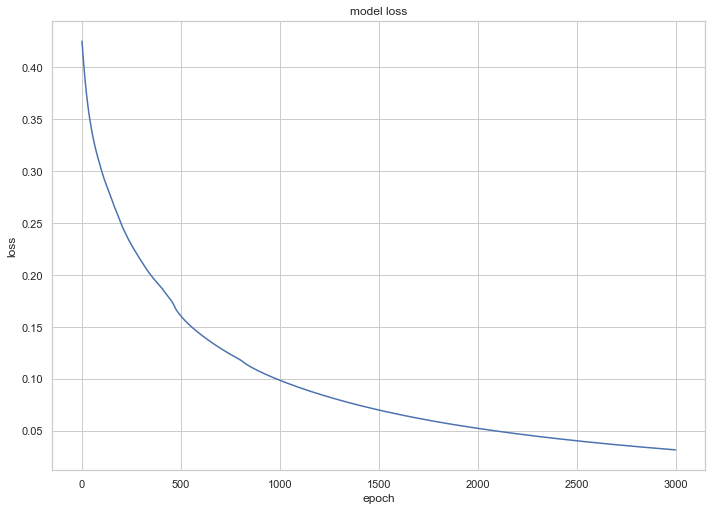

Size: 1162.000000 bits - FPR: 0.037736 



Number of nodes: 2


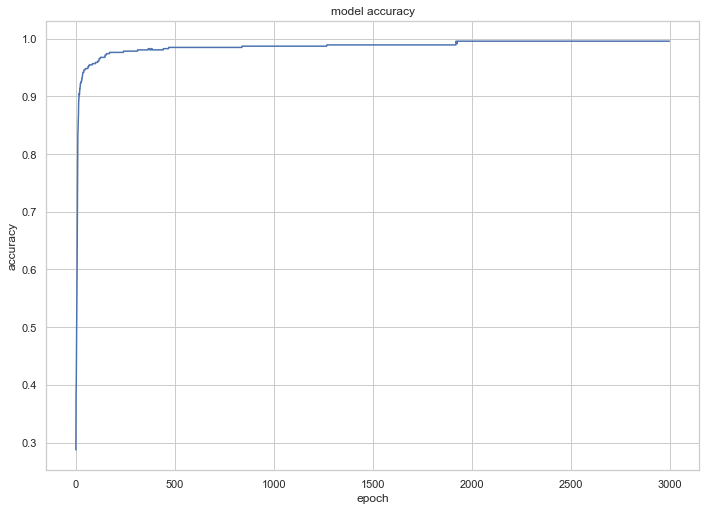

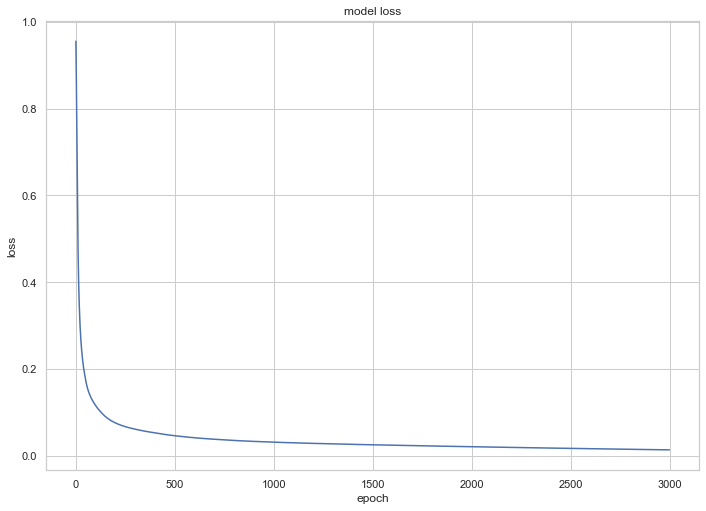

Size: 2289.000000 bits - FPR: 0.018868 



Number of nodes: 3


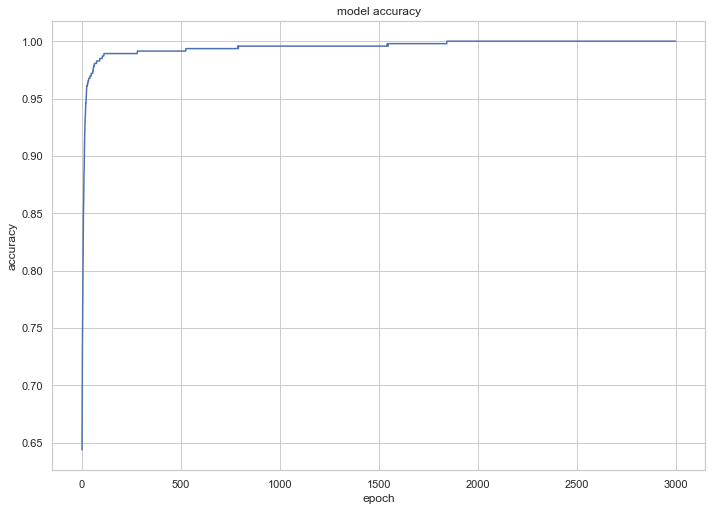

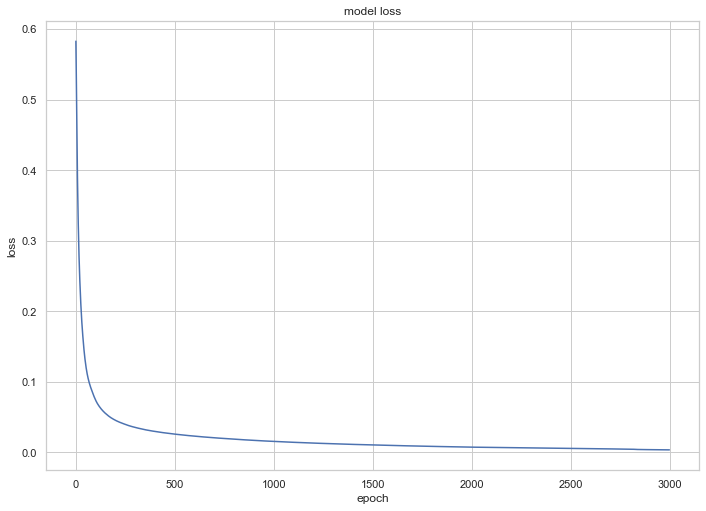

Size: 3415.000000 bits - FPR: 0.047170 



Number of nodes: 4


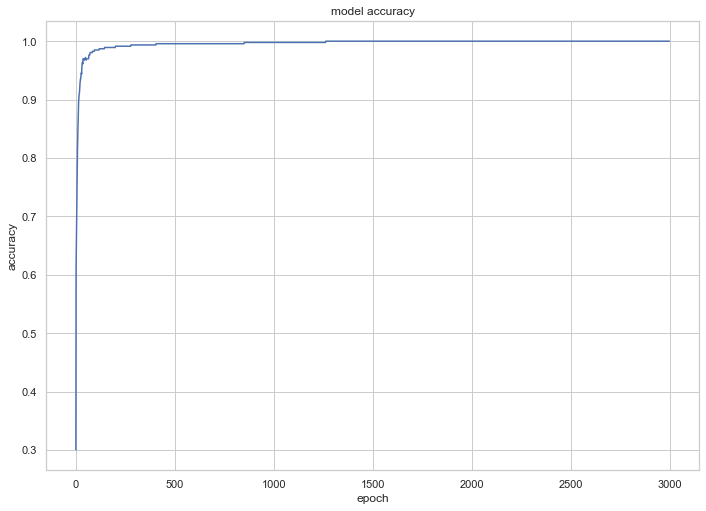

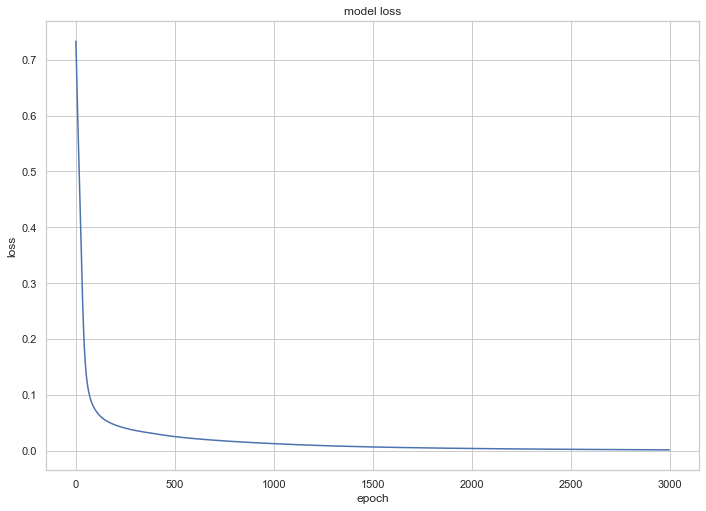

Size: 4541.000000 bits - FPR: 0.047170 



Number of nodes: 5


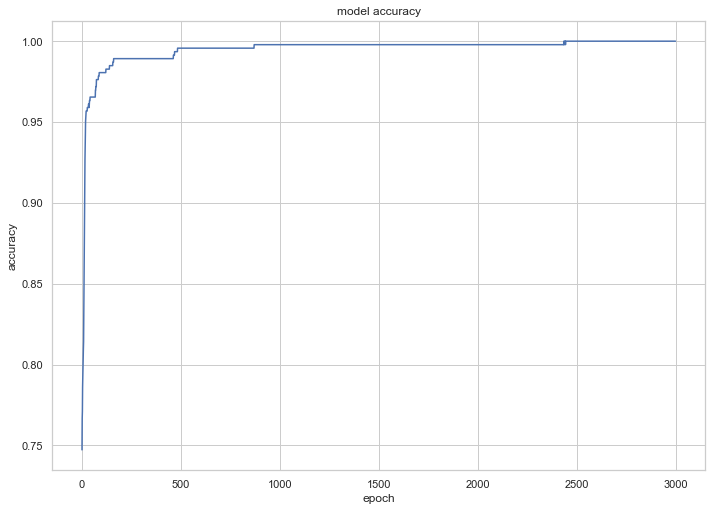

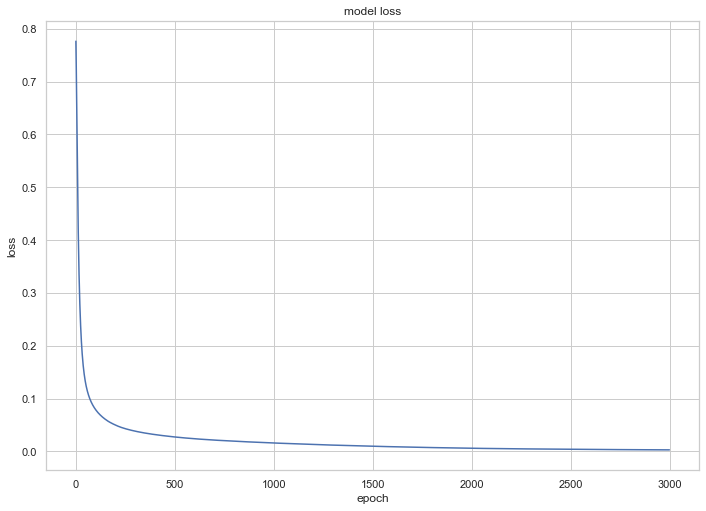

Size: 5668.000000 bits - FPR: 0.047170 



Number of nodes: 6


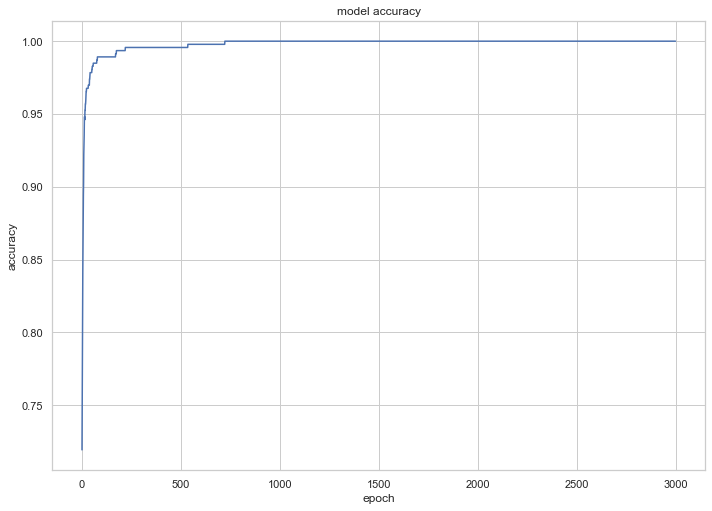

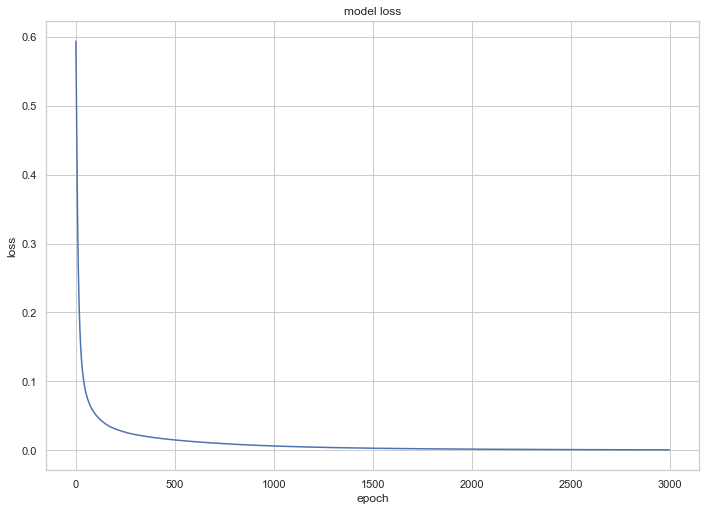

Size: 6794.000000 bits - FPR: 0.037736 



Number of nodes: 7


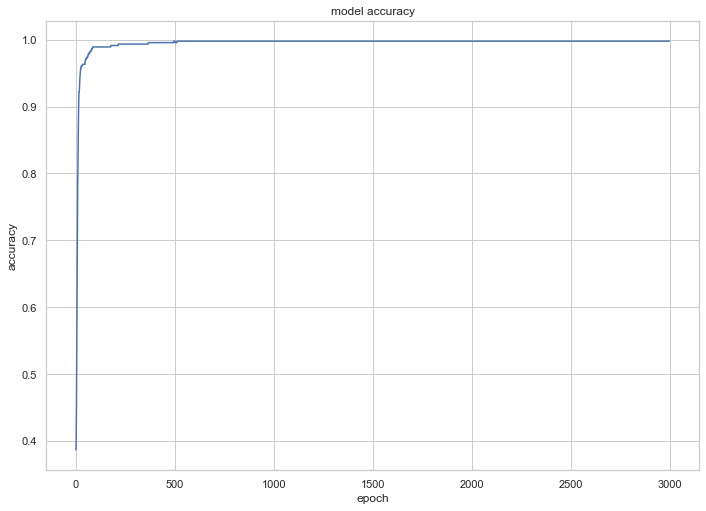

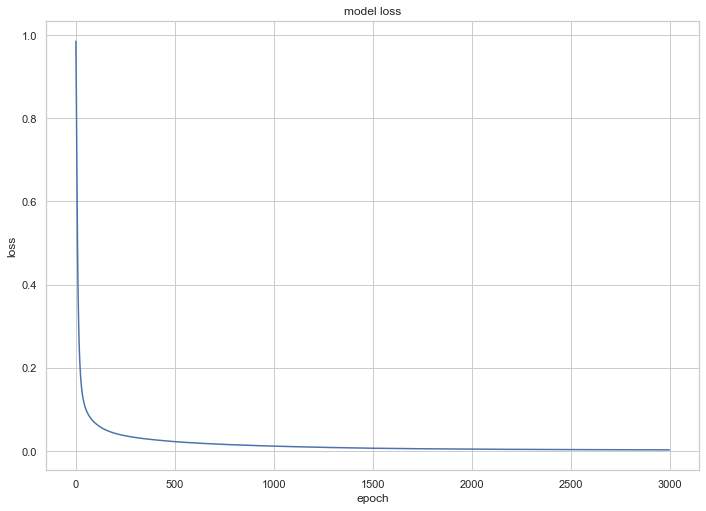

Size: 7921.000000 bits - FPR: 0.037736 



Number of nodes: 8


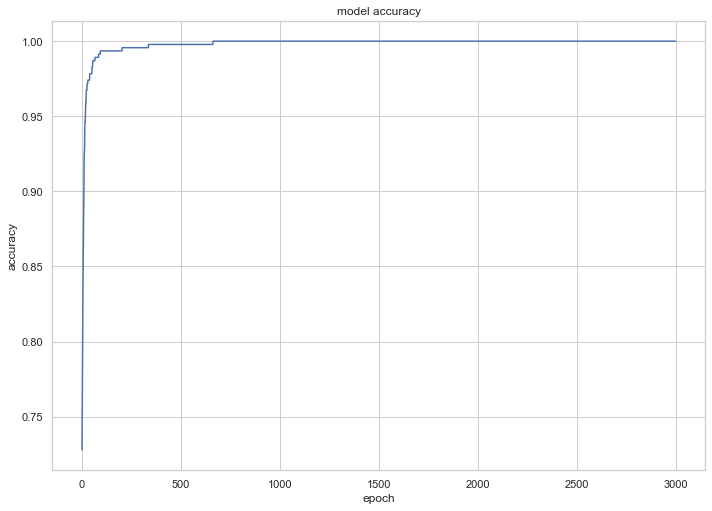

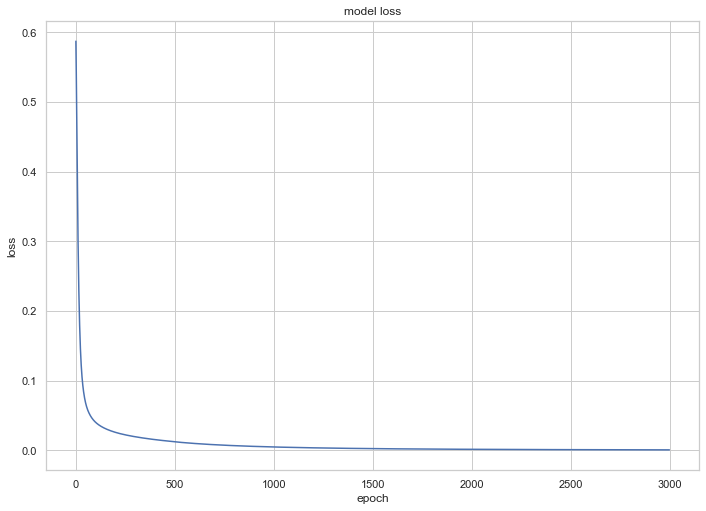

Size: 9047.000000 bits - FPR: 0.037736 



Number of nodes: 9


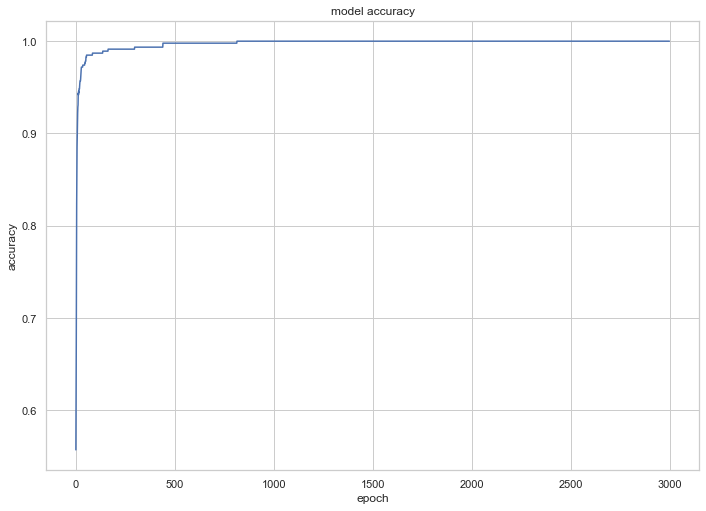

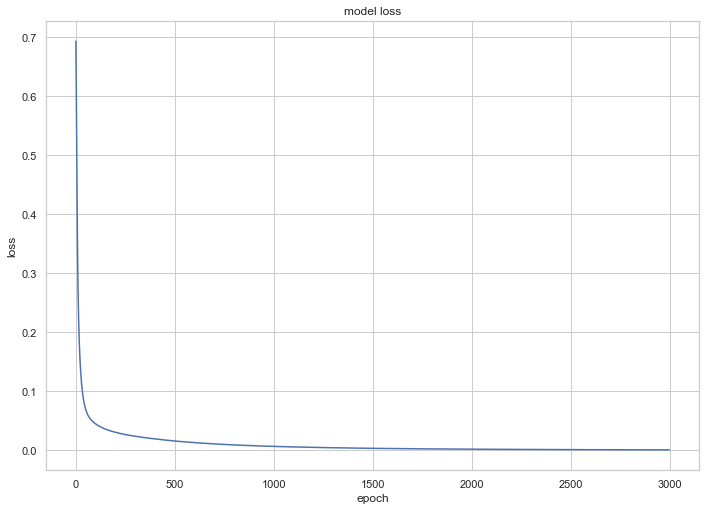

Size: 10173.000000 bits - FPR: 0.028302 



Number of nodes: 10


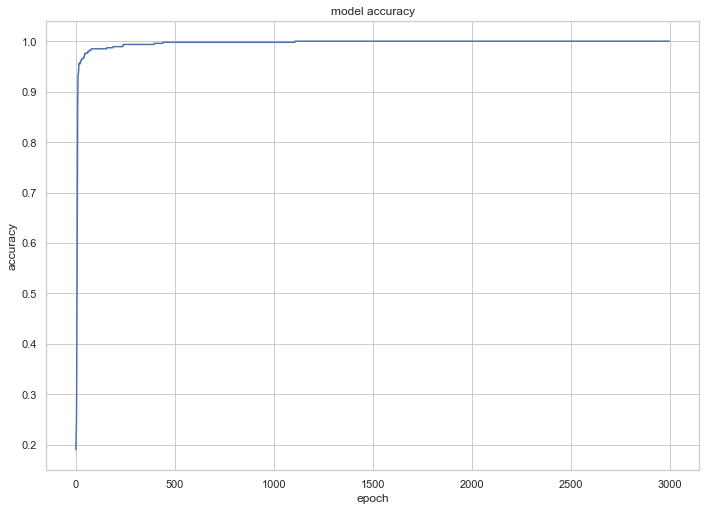

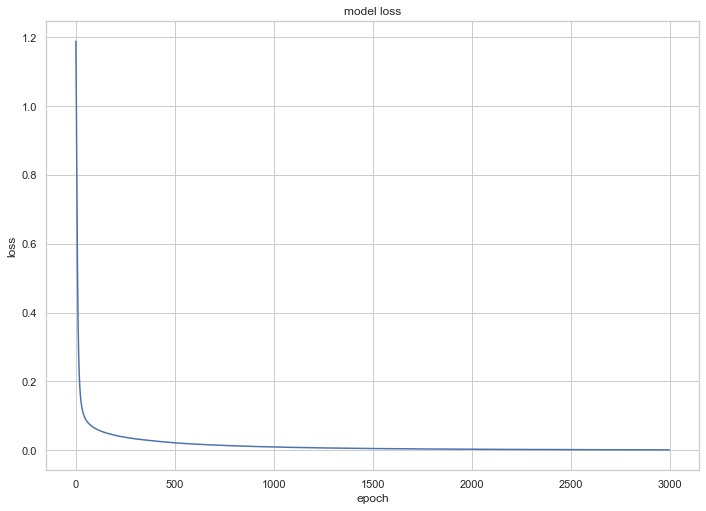

Size: 11300.000000 bits - FPR: 0.028302 



Number of nodes: 11


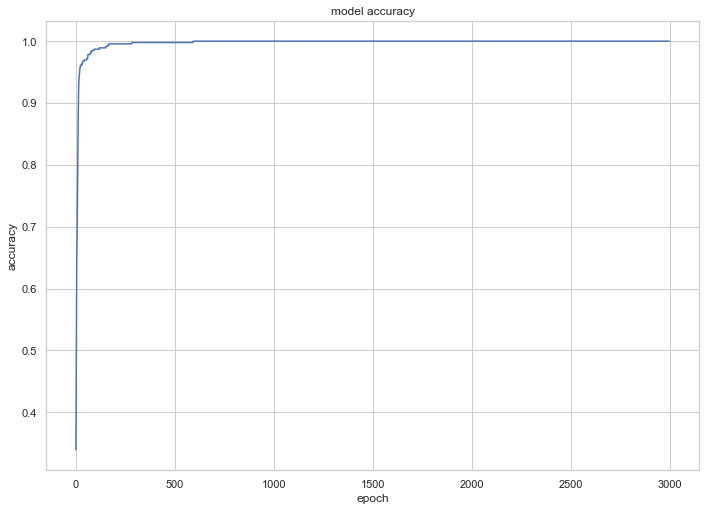

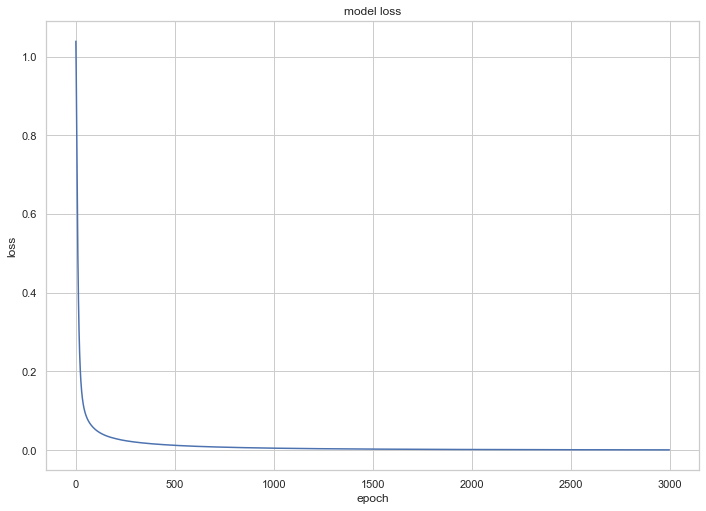

Size: 12426.000000 bits - FPR: 0.047170 



Number of nodes: 12


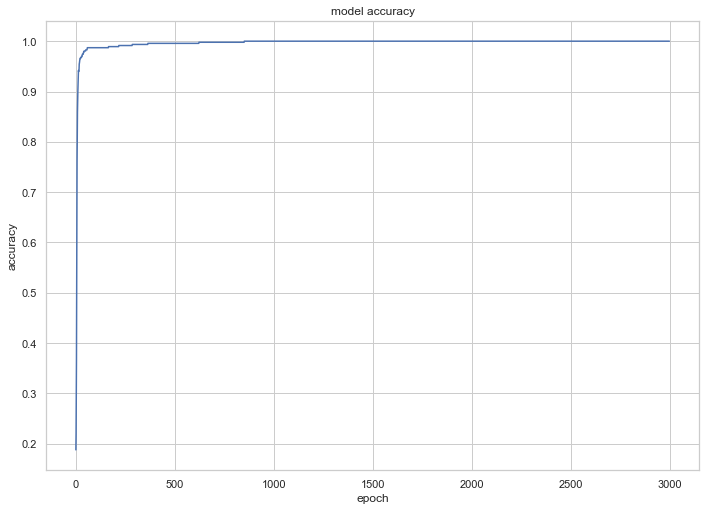

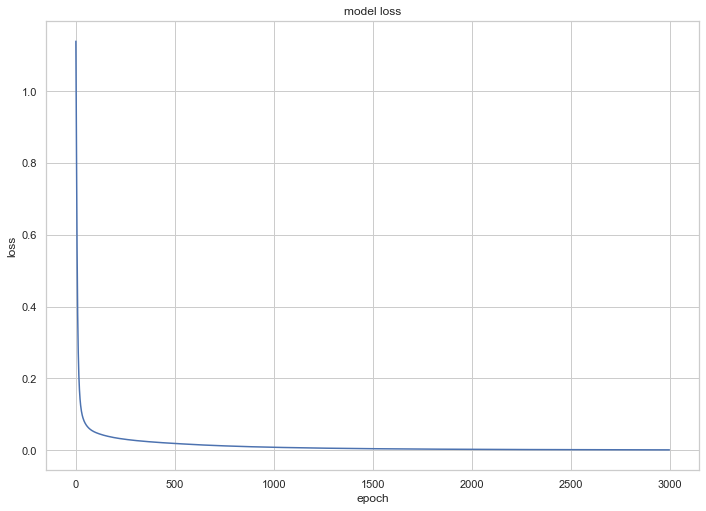

Size: 13553.000000 bits - FPR: 0.037736 



Number of nodes: 13


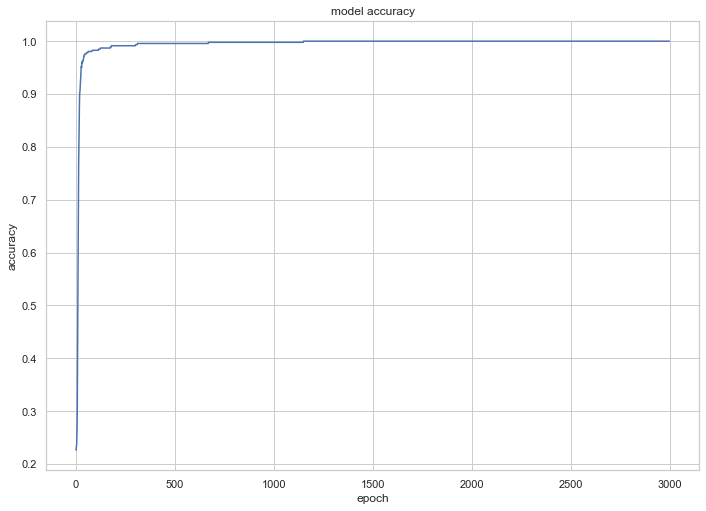

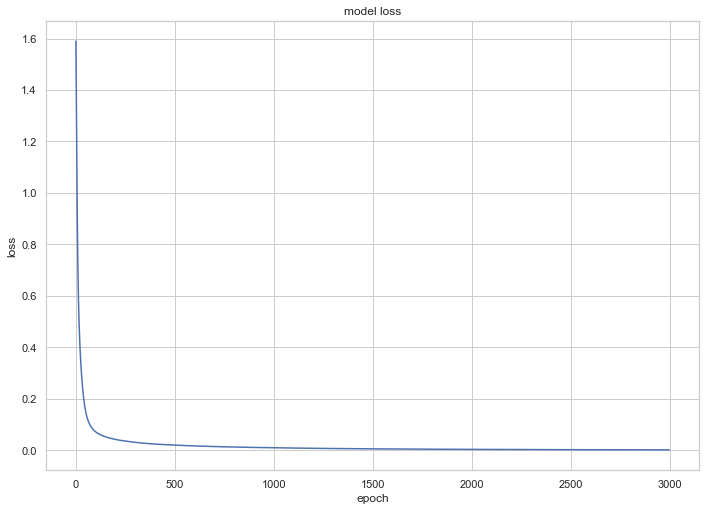

Size: 14679.000000 bits - FPR: 0.037736 



Number of nodes: 14


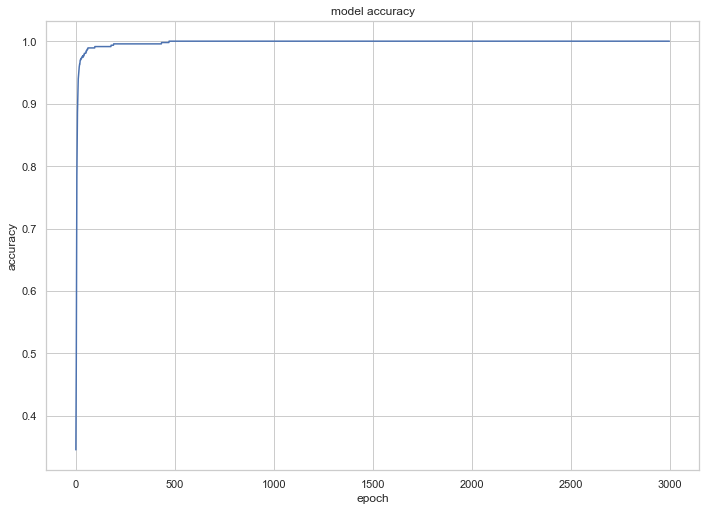

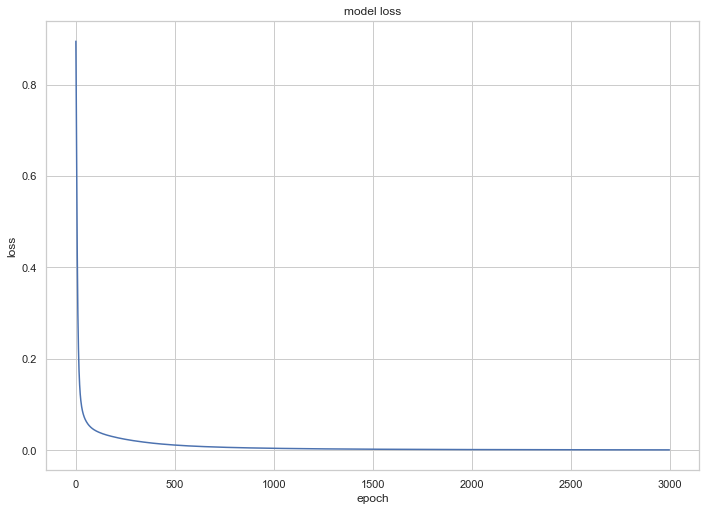

Size: 15805.000000 bits - FPR: 0.037736 



Number of nodes: 15


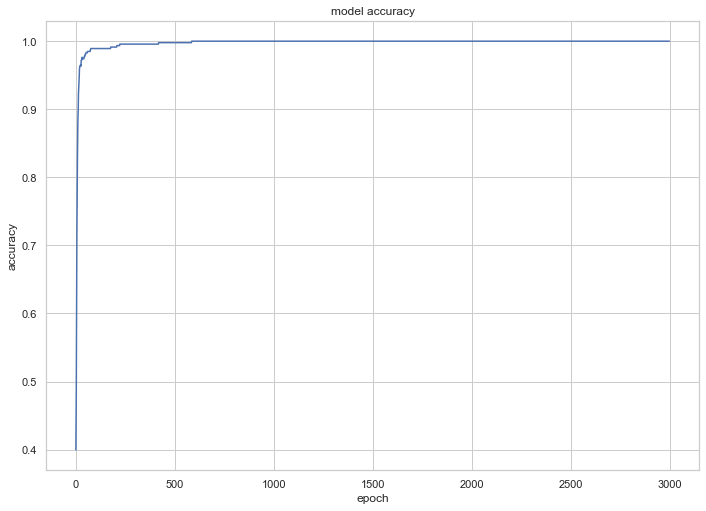

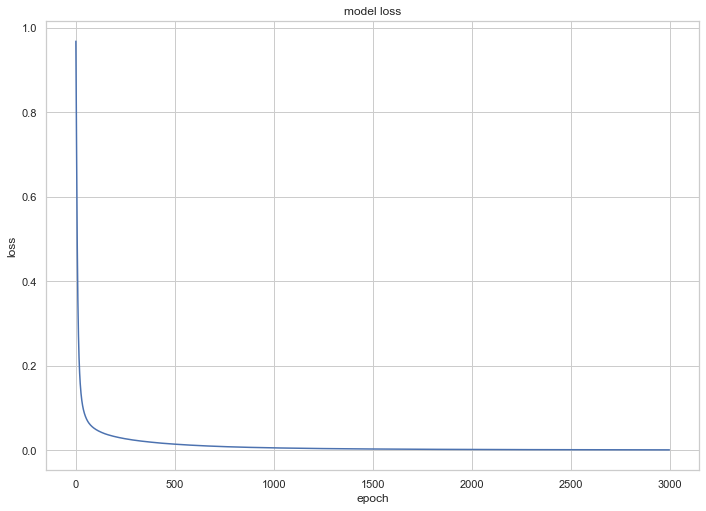

Size: 16932.000000 bits - FPR: 0.028302 



Number of nodes: 16


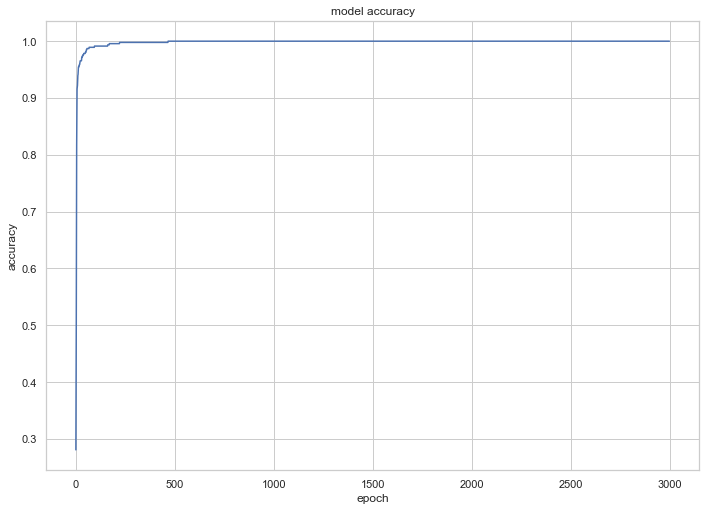

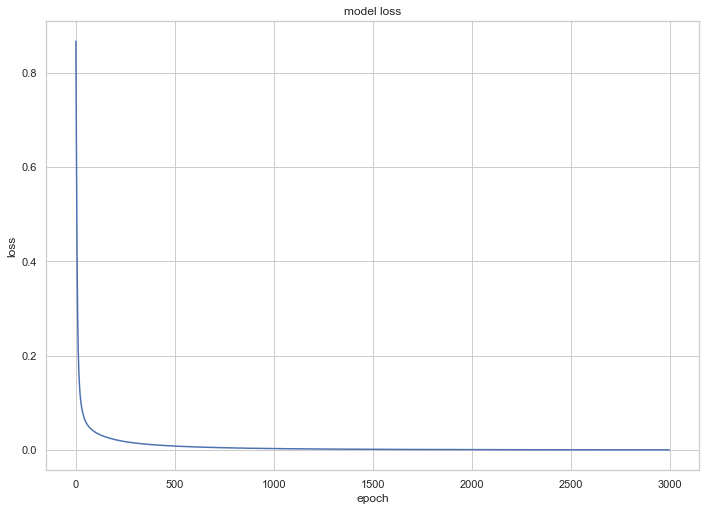

Size: 18058.000000 bits - FPR: 0.037736 



Number of nodes: 17


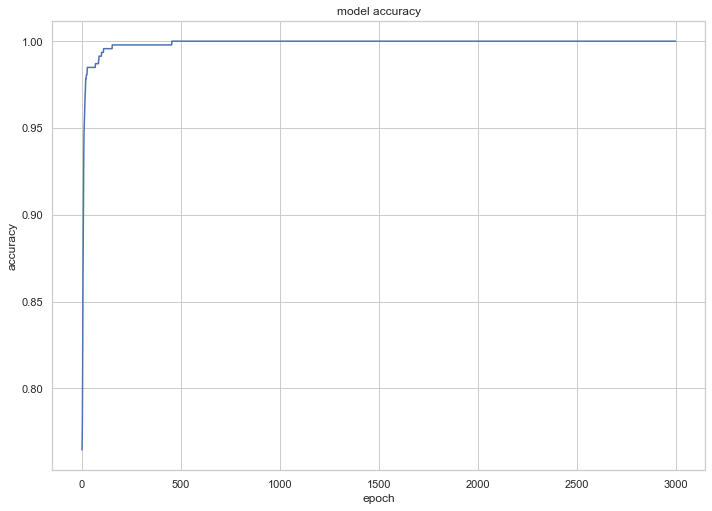

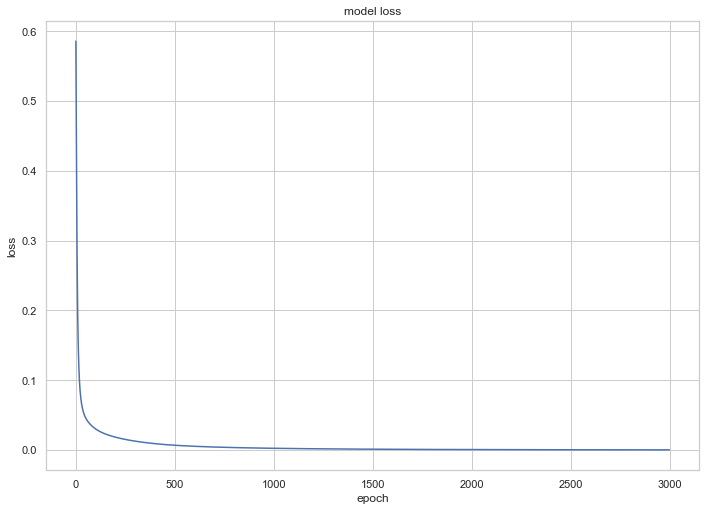

Size: 19185.000000 bits - FPR: 0.047170 



Number of nodes: 18


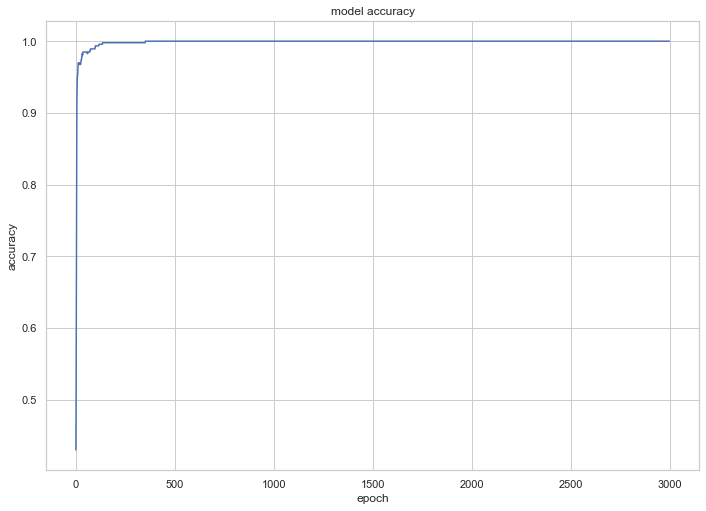

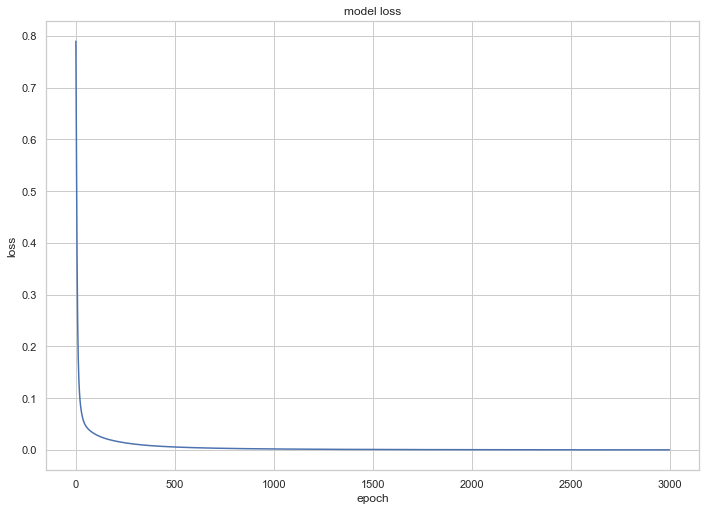

Size: 20311.000000 bits - FPR: 0.047170 



Number of nodes: 19


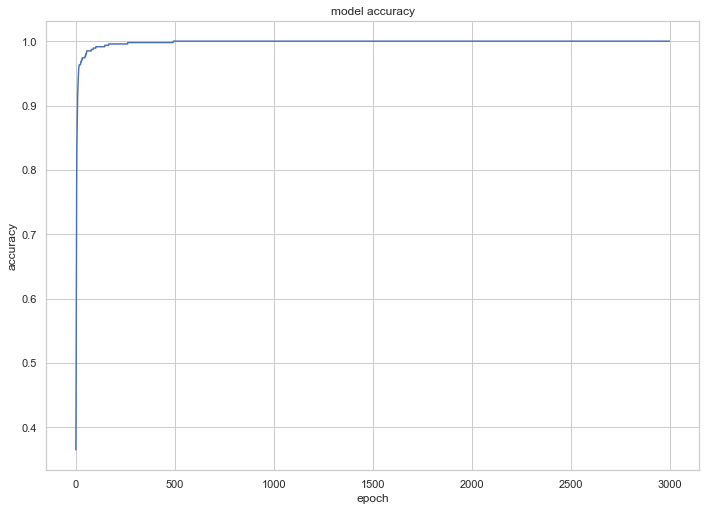

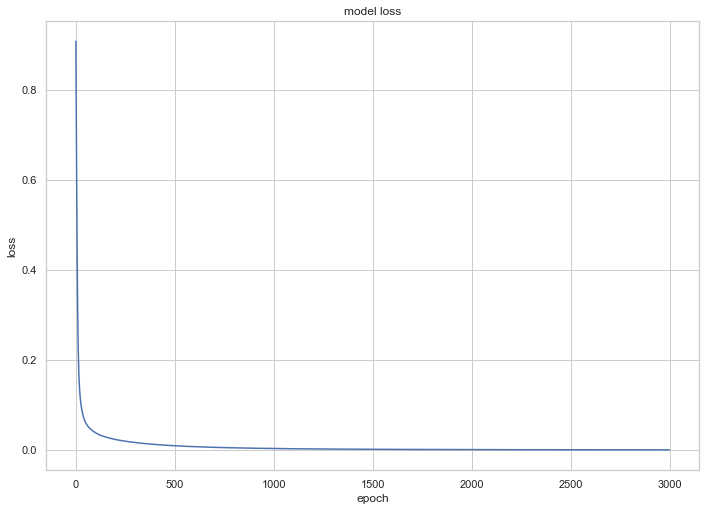

Size: 21437.000000 bits - FPR: 0.047170 



Number of nodes: 20


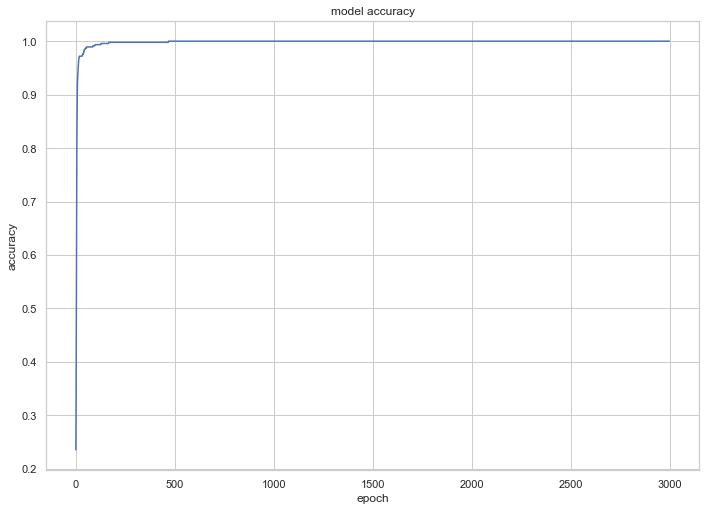

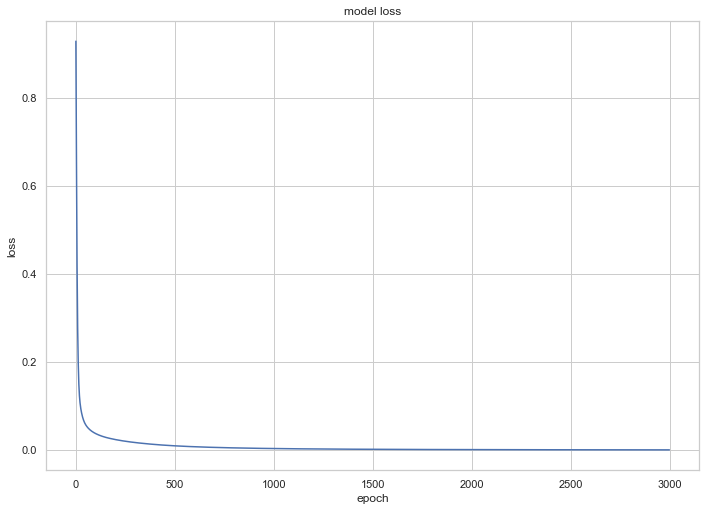

Size: 22564.000000 bits - FPR: 0.047170 





In [116]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,20,3000,fpr_values_kraska,size_values_kraska)

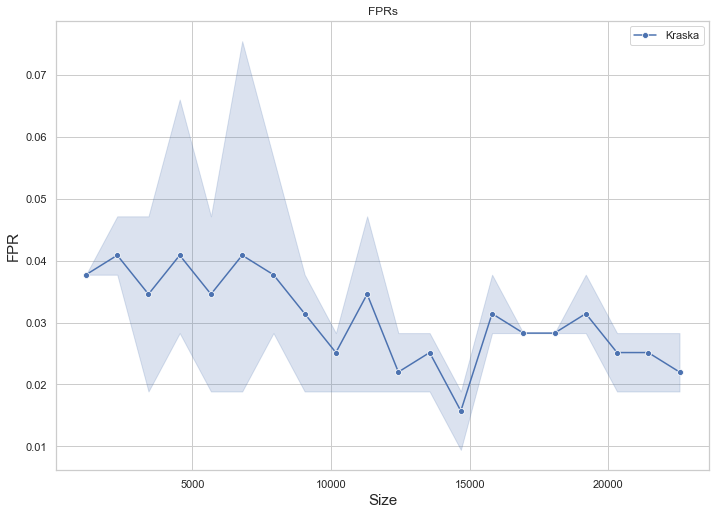

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection model

In [14]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [15]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [16]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)




Size: 395 Bits - FPR: 0.075472 



Size: 405 Bits - FPR: 0.037736 



Size: 415 Bits - FPR: 0.056604 



Size: 425 Bits - FPR: 0.066038 



Size: 435 Bits - FPR: 0.037736 



Size: 445 Bits - FPR: 0.084906 



Size: 455 Bits - FPR: 0.075472 



Size: 465 Bits - FPR: 0.084906 



Size: 475 Bits - FPR: 0.132075 



Size: 485 Bits - FPR: 0.056604 



Size: 495 Bits - FPR: 0.094340 



Size: 505 Bits - FPR: 0.056604 



Size: 515 Bits - FPR: 0.122642 



Size: 525 Bits - FPR: 0.084906 



Size: 535 Bits - FPR: 0.160377 



Size: 545 Bits - FPR: 0.103774 



Size: 555 Bits - FPR: 0.075472 



Size: 565 Bits - FPR: 0.198113 



Size: 575 Bits - FPR: 0.075472 



Size: 585 Bits - FPR: 0.047170 



Size: 595 Bits - FPR: 0.094340 



Size: 605 Bits - FPR: 0.094340 



Size: 615 Bits - FPR: 0.066038 



Size: 625 Bits - FPR: 0.028302 



Size: 635 Bits - FPR: 0.018868 



Size: 645 Bits - FPR: 0.094340 



Size: 655 Bits - FPR: 0.037736 



Size: 665 Bits - FPR: 0.056604 



Size: 675 Bits - 

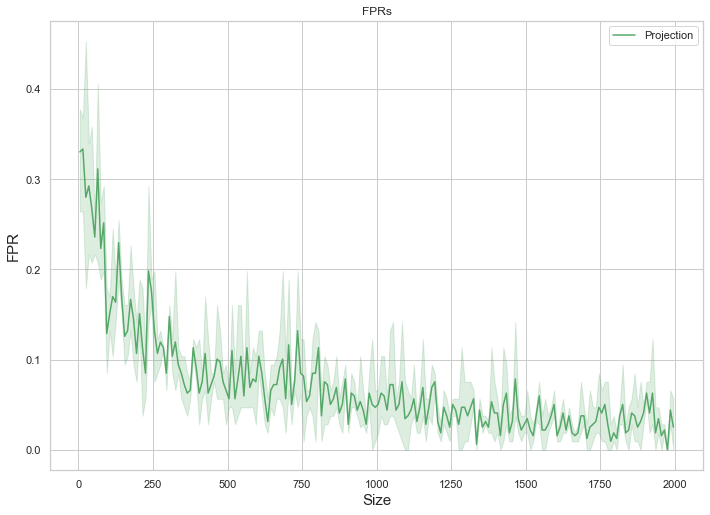

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Normal Bloom Filter Values

In [109]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [19]:
print(sum(y_train))
print(len(y_train))

[357]
463


In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
[357]


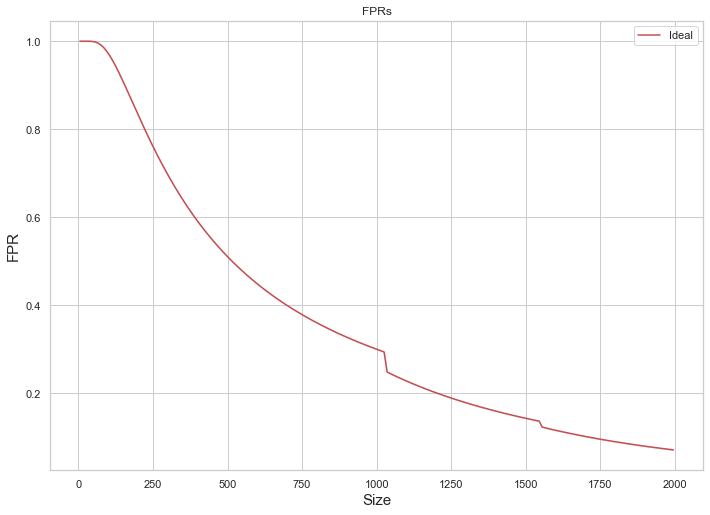

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

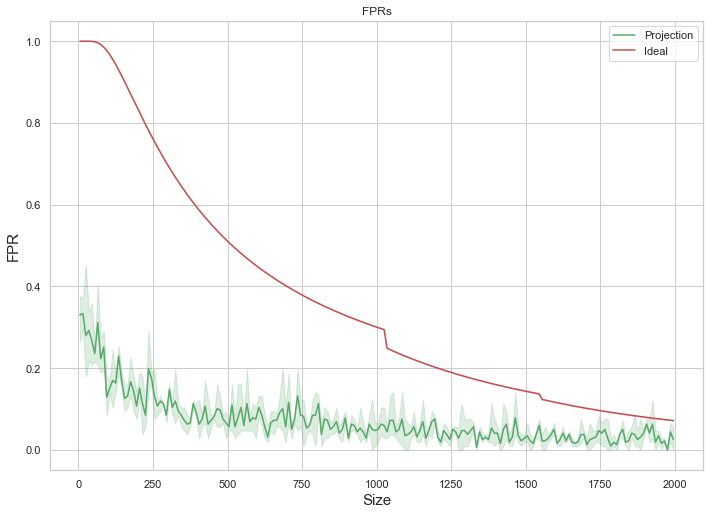

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between all 3 models

In [23]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [34]:
# Ran only once instead of thrice as size_values_kraska already has tripple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(357, 30)
Size: 1162 Bits - FPR: 0.037736 



Size: 2289 Bits - FPR: 0.018868 



Size: 3415 Bits - FPR: 0.009434 



Size: 4541 Bits - FPR: 0.009434 



Size: 5668 Bits - FPR: 0.000000 



Size: 6794 Bits - FPR: 0.000000 



Size: 7921 Bits - FPR: 0.000000 



Size: 9047 Bits - FPR: 0.000000 



Size: 10173 Bits - FPR: 0.000000 



Size: 11300 Bits - FPR: 0.000000 



Size: 12426 Bits - FPR: 0.000000 



Size: 13553 Bits - FPR: 0.000000 



Size: 14679 Bits - FPR: 0.000000 



Size: 15805 Bits - FPR: 0.000000 



Size: 16932 Bits - FPR: 0.000000 



Size: 18058 Bits - FPR: 0.000000 



Size: 19185 Bits - FPR: 0.000000 



Size: 20311 Bits - FPR: 0.000000 



Size: 21437 Bits - FPR: 0.000000 



Size: 22564 Bits - FPR: 0.000000 



Size: 1162 Bits - FPR: 0.094340 



Size: 2289 Bits - FPR: 0.028302 



Size: 3415 Bits - FPR: 0.009434 



Size: 4541 Bits - FPR: 0.028302 



Size: 5668 Bits - FPR: 0.009434 



Size: 6794 Bits - FPR: 0.000000 



Size: 7921 Bits - FPR: 0.000000 



Size: 

In [35]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)

60
[357]


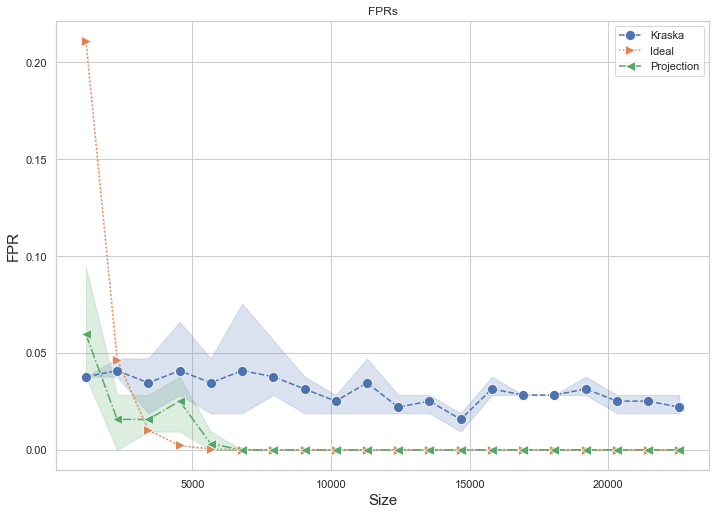

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection Model with only 1 Hash Function

In [37]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = 1  #Setting k as 1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [38]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)




Size: 395 Bits - FPR: 0.103774 



Size: 405 Bits - FPR: 0.160377 



Size: 415 Bits - FPR: 0.188679 



Size: 425 Bits - FPR: 0.066038 



Size: 435 Bits - FPR: 0.094340 



Size: 445 Bits - FPR: 0.028302 



Size: 455 Bits - FPR: 0.160377 



Size: 465 Bits - FPR: 0.103774 



Size: 475 Bits - FPR: 0.047170 



Size: 485 Bits - FPR: 0.122642 



Size: 495 Bits - FPR: 0.066038 



Size: 505 Bits - FPR: 0.216981 



Size: 515 Bits - FPR: 0.028302 



Size: 525 Bits - FPR: 0.160377 



Size: 535 Bits - FPR: 0.150943 



Size: 545 Bits - FPR: 0.084906 



Size: 555 Bits - FPR: 0.066038 



Size: 565 Bits - FPR: 0.009434 



Size: 575 Bits - FPR: 0.066038 



Size: 585 Bits - FPR: 0.113208 



Size: 595 Bits - FPR: 0.028302 



Size: 605 Bits - FPR: 0.066038 



Size: 615 Bits - FPR: 0.122642 



Size: 625 Bits - FPR: 0.047170 



Size: 635 Bits - FPR: 0.056604 



Size: 645 Bits - FPR: 0.056604 



Size: 655 Bits - FPR: 0.066038 



Size: 665 Bits - FPR: 0.047170 



Size: 675 Bits - 

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Comparing new Projection Model with Ideal Bloom Filter

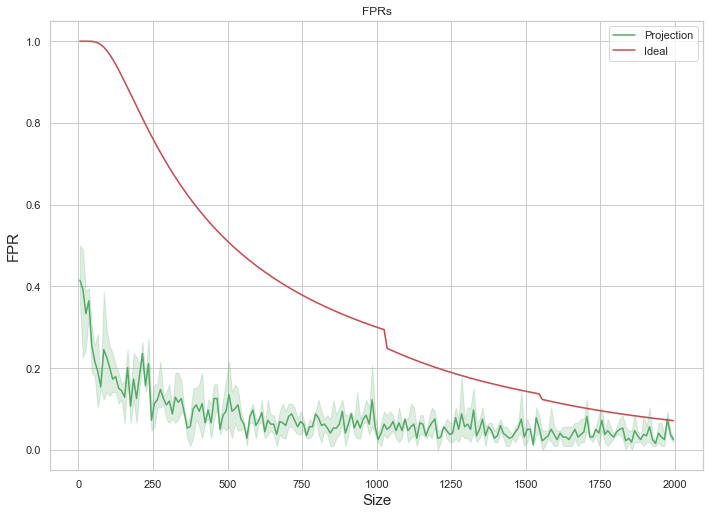

In [40]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Giving independent bitarrays for each hash function in Projection Model

In [97]:
class Projection_Multiple_Array_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1    
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = (size//hash_count) # Size of each bitarray
        self.hash_count = hash_count
        arrays = []
        for i in range(0,hash_count):
            array = bitarray(size//hash_count)
            array.setall(0)
            arrays += [array]
        self.bit_arrays = arrays

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
            
    def lookup(self, x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values[0])):
            for j in range(0,self.hash_count):
                if(self.bit_arrays[j][int(hash_values[i][j])] == 0):
                    return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(pos_hash_values)):
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(pos_hash_values[i][j])] == 0):
                return -1
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [98]:
def get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]




Size: 395 Bits - FPR: 0.066038 



Size: 405 Bits - FPR: 0.132075 



Size: 415 Bits - FPR: 0.122642 



Size: 425 Bits - FPR: 0.066038 



Size: 435 Bits - FPR: 0.084906 



Size: 445 Bits - FPR: 0.160377 



Size: 455 Bits - FPR: 0.037736 



Size: 465 Bits - FPR: 0.094340 



Size: 475 Bits - FPR: 0.056604 



Size: 485 Bits - FPR: 0.103774 



Size: 495 Bits - FPR: 0.141509 



Size: 505 Bits - FPR: 0.141509 



Size: 515 Bits - FPR: 0.066038 



Size: 525 Bits - FPR: 0.066038 



Size: 535 Bits - FPR: 0.047170 



Size: 545 Bits - FPR: 0.037736 



Size: 555 Bits - FPR: 0.037736 



Size: 565 Bits - FPR: 0.150943 



Size: 575 Bits - FPR: 0.198113 



Size: 585 Bits - FPR: 0.066038 



Size: 595 Bits - FPR: 0.047170 



Size: 605 Bits - FPR: 0.056604 



Size: 615 Bits - FPR: 0.056604 



Size: 625 Bits - FPR: 0.037736 



Size: 635 Bits - FPR: 0.056604 



Size: 645 Bits - FPR: 0.150943 



Size: 655 Bits - FPR: 0.028302 



Size: 665 Bits - FPR: 0.056604 



Size: 675 Bits - 

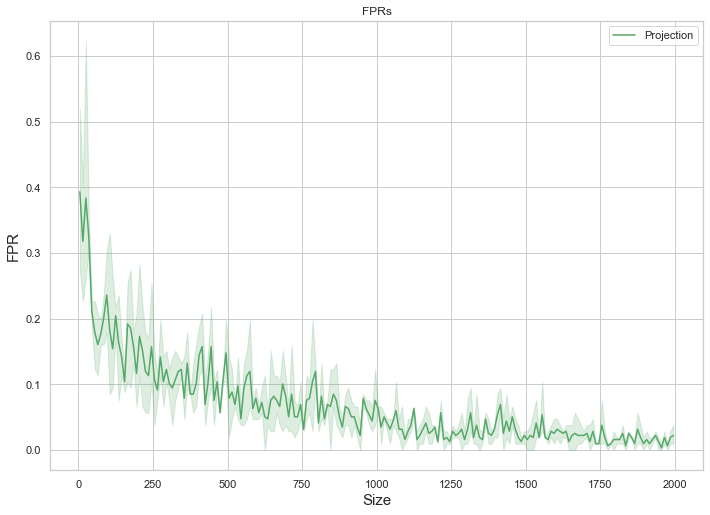

In [99]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

In [100]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

600
[357]


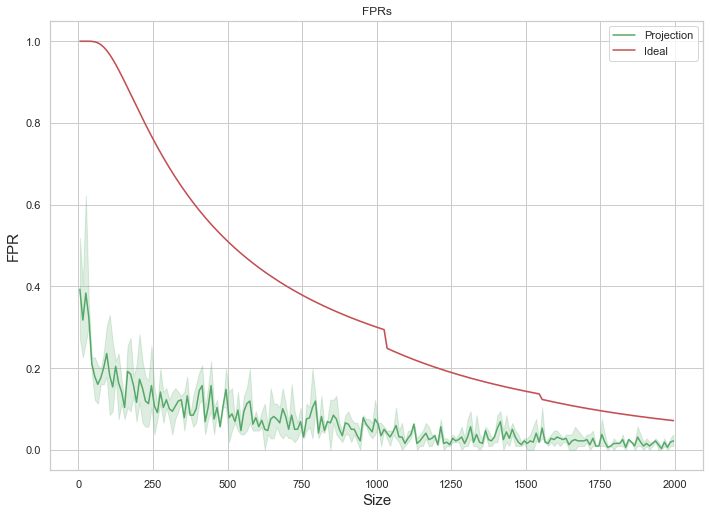

In [101]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection using Kernel

In [119]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        self.unit_vectors = vectors #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = self.kernel_rbf(X,0.1)
        hash_values = (projections*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    def kernel_rbf(self,X,gamma):
        projections = np.zeros((X.shape[0],self.unit_vectors.shape[0]))
        for i in range(0,X.shape[0]):
            for j in range(0,self.unit_vectors.shape[0]):
                val=math.exp((-gamma)*np.linalg.norm(X[i] - self.unit_vectors[j]))
                projections[i,j]=val
        return projections
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    #print(bf.bit_array)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)



def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    #print(neg_hash_values,"neg hashes test")
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [105]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        #k = eff_k(m,n,1)
        k=1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [106]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,50,20,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(357, 30)
Size: 5 Bits - FPR: 1.000000 



Size: 55 Bits - FPR: 0.820755 



Size: 105 Bits - FPR: 0.773585 



Size: 155 Bits - FPR: 0.603774 



Size: 205 Bits - FPR: 0.622642 



Size: 255 Bits - FPR: 0.632075 



Size: 305 Bits - FPR: 0.603774 



Size: 355 Bits - FPR: 0.537736 



Size: 405 Bits - FPR: 0.471698 



Size: 455 Bits - FPR: 0.424528 



Size: 505 Bits - FPR: 0.452830 



Size: 555 Bits - FPR: 0.330189 



Size: 605 Bits - FPR: 0.386792 



Size: 655 Bits - FPR: 0.358491 



Size: 705 Bits - FPR: 0.386792 



Size: 755 Bits - FPR: 0.518868 



Size: 805 Bits - FPR: 0.330189 



Size: 855 Bits - FPR: 0.245283 



Size: 905 Bits - FPR: 0.358491 



Size: 955 Bits - FPR: 0.452830 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

(357, 30)
Size: 5 Bits - FPR: 1.000000 



Size: 55 Bits - FPR: 0.801887 



Size: 105 Bits - FPR: 0.735849 



Size: 155 Bits - FPR: 0.707547 



Size: 205 Bits - FPR: 0.518868 



Size: 255 Bits - FPR: 0.613208 



Size: 305 Bi

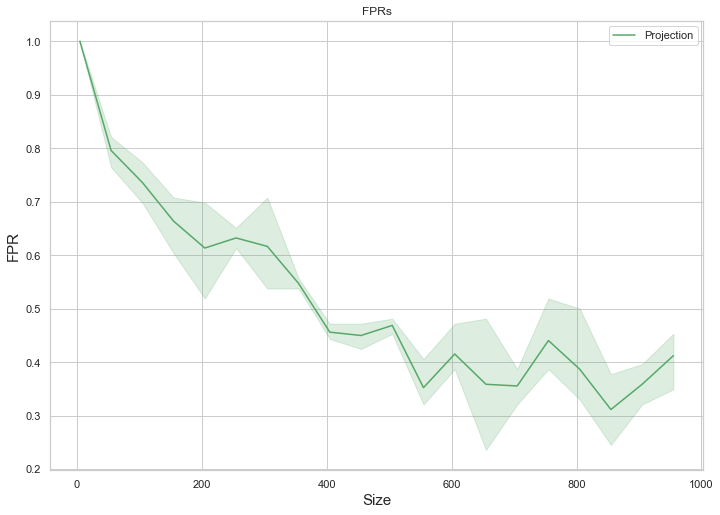

In [107]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [110]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

60
[357]


In [111]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

,Size,Projection FPR,Ideal FPR
0,5,1.000000,1.000000
1,55,0.820755,0.998571
2,105,0.773585,0.967166
3,155,0.603774,0.900807
4,205,0.622642,0.825482


In [112]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/BreastCancer_kernel.csv')

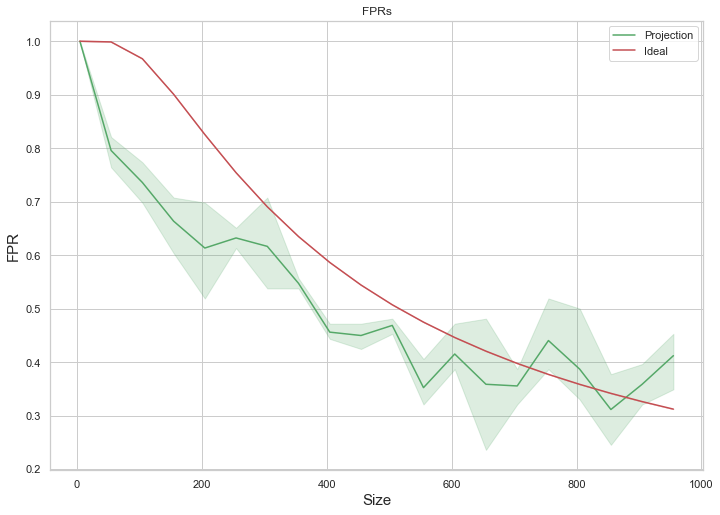

In [113]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Comparison with Kraska and Ideal 

In [120]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]


In [121]:
# Ran only once instead of thrice as size_values_kraska already has triple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(357, 30)
Size: 1162 Bits - FPR: 0.330189 



Size: 2289 Bits - FPR: 0.226415 



Size: 3415 Bits - FPR: 0.216981 



Size: 4541 Bits - FPR: 0.216981 



Size: 5668 Bits - FPR: 0.150943 



Size: 6794 Bits - FPR: 0.075472 



Size: 7921 Bits - FPR: 0.113208 



Size: 9047 Bits - FPR: 0.047170 



Size: 10173 Bits - FPR: 0.188679 



Size: 11300 Bits - FPR: 0.037736 



Size: 12426 Bits - FPR: 0.037736 



Size: 13553 Bits - FPR: 0.047170 



Size: 14679 Bits - FPR: 0.018868 



Size: 15805 Bits - FPR: 0.047170 



Size: 16932 Bits - FPR: 0.056604 



Size: 18058 Bits - FPR: 0.009434 



Size: 19185 Bits - FPR: 0.047170 



Size: 20311 Bits - FPR: 0.028302 



Size: 21437 Bits - FPR: 0.018868 



Size: 22564 Bits - FPR: 0.009434 



Size: 1162 Bits - FPR: 0.339623 



Size: 2289 Bits - FPR: 0.254717 



Size: 3415 Bits - FPR: 0.207547 



Size: 4541 Bits - FPR: 0.179245 



Size: 5668 Bits - FPR: 0.132075 



Size: 6794 Bits - FPR: 0.122642 



Size: 7921 Bits - FPR: 0.113208 



Size: 

In [122]:
n = sum(y_train)
y_ideal=[]
for x in size_values_kraska:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

60
[357]


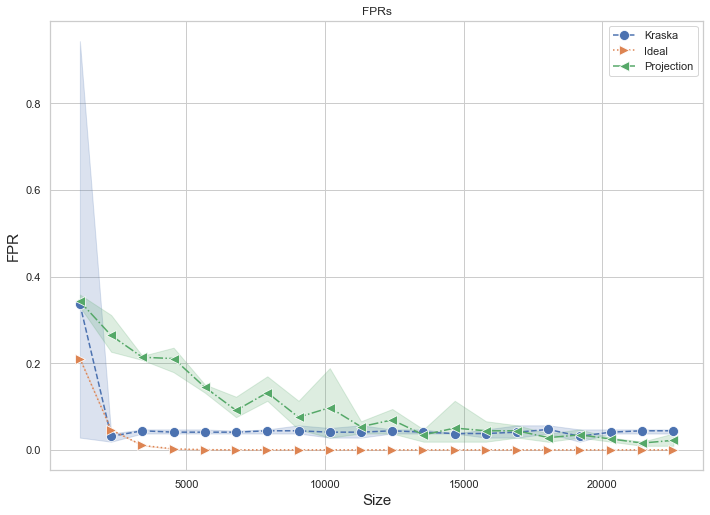

In [124]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [126]:
saved_data = list(zip(size_values_kraska, fpr_values_kraska,fpr_values_projection, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size','Kraska FPR', 'Projection_kernel FPR', 'Ideal FPR'])
df.head()

,Size,Kraska FPR,Projection_kernel FPR,Ideal FPR
0,1162,0.943396,0.330189,0.210873
1,2289,0.037736,0.226415,0.046431
2,3415,0.037736,0.216981,0.010238
3,4541,0.037736,0.216981,0.002258
4,5668,0.037736,0.150943,0.000487


In [127]:
df.to_csv('E:\SURA Data\BreastCancer_Kraska_Projectionkernel.csv')